This notebook shows the results of research on HLA-A vs HLA-B predictive ability of random forest.

The tested hypothesis was whether one of these alleles could be a factor which affected the result of immunogenicity prediction.

Different data was used to train the model. To start, dataset contained only amino acid features, then Kyte-Doolittle hydrophobicity scale was added and after that all other hydrophobicity scales (which were correlated a lot, however, a further research should be carried out to find out which of them contain the most valuable information - feature selection is needed). The same steps apply to Kidera factors data.

Finally, the results were assessed altogether. Seems like there is no difference between quality of predictions for allele subsets. However, additional statistical testing may be required to prove this conclusion.

In [1]:
%matplotlib inline
from util.aa_properties import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [2]:
# "TCR contact residue hydrophobicity is a hallmark of immunogenic CD8+ T cell epitopes" dataset
# TODO: link here

dataset = pd.read_csv('data/pnas_dataset.csv', sep=';')

In [3]:
# some of the columns are read with leading space - replacing column names

dataset.columns = ['Epitope', 'Epitope Start', 'Epitope End', 'MHC Allele',
       'Epitope Source Organism Name', 'Length', 'Immunogenicity']

In [4]:
dataset.columns

Index(['Epitope', 'Epitope Start', 'Epitope End', 'MHC Allele',
       'Epitope Source Organism Name', 'Length', 'Immunogenicity'],
      dtype='object')

In [5]:
# function for mice filtering from the dataset

def filter_mice(seq):
    return 'Human' if seq.startswith('HLA') else 'Mouse'

In [40]:
# data preparation pipeline

def prepare_data(df, aa=True, hydropathy=False, hydropathy_all=False, kidera=False):
    
    # creating Host column - 'Human' or 'Mouse'
    df['Host'] = df['MHC Allele'].apply(filter_mice)
    
    # keeping only Human hosts
    df = df.loc[df.Host == 'Human']
    
    # will drop these rows
    to_drop = df.loc[(df['Epitope Source Organism Name'] == 'Homo sapiens') & 
                          (df['Immunogenicity'] == 'Positive')].index
    df.drop(to_drop, inplace=True)
    
    # adding amino acid & kidera scores (sum)
    df = df.merge(df.Epitope.apply(aaprop_sequence), right_index=True, left_index=True)
    
    # here we set columns which will remain in the dataset (either aa props or kidera factors)
    if aa:
        keep = ['alpha', 'charge', 'core', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'count', 
                'strength', 'disorder', 'mjenergy', 'target', 'Allele', 'Organism']
    elif kidera:
        keep = ['beta', 'kf1', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'kf10', 'Allele', 'target', 
                'Organism']
        
    # if we do use hydro features at all:
    # whether to use hydro features together
    if hydropathy_all:
        # adding hydrophobicity score (sum)
        scales = ['Kyte-Doolittle', 'Hopp-Woods', 'Cornette', 'Eisenberg', 'Rose', 'Janin', 'Engelman GES']
            
        df = df.merge(df.Epitope.apply(lambda x: score_hydrophobicity_sequence(x, scales)), 
                      right_index=True, left_index=True)
        keep.extend(scales)
        
    # or to keep only Kyte-Doolittle
    elif hydropathy:
        keep.append('hydropathy')
    
    # collecting unique alleles 
    alleles = df['MHC Allele'].unique()
    
    # keeping only 5 first symbols from MHC Allelle (should be: HLA-S*XX:XX)
    alleles_tmp = {allele: allele[:5] for allele in alleles}
    
    # encoder for alleles to get ints
    le = LabelEncoder()
    le.fit(list(set(alleles_tmp.values())))

    # first, mapping alleles to their short versions
    df['allele'] = df['MHC Allele'].map(alleles_tmp)

    # encoding short names
    df['Allele'] = le.transform(df['allele'])
    
    # just to ensure A and B are 0 and 1
    a_b_alleses = le.transform(np.array(['HLA-A', 'HLA-B']))
    
    # encoder for organisms
    # TODO: group organisms?
    le_organisms = LabelEncoder()
    le_organisms.fit(df['Epitope Source Organism Name'])
    df['Organism'] = le_organisms.transform(df['Epitope Source Organism Name'])
    
    # target encoding 
    encode_target = {'Positive': 1, 'Negative': 0}
    df['target'] = df.Immunogenicity.map(encode_target) 
    
    return df[keep]

In [134]:
feature_grid = [[True, False, False, False], [True, True, False, False], [True, False, True, False], 
                [False, False, False, True], [False, True, False, True], [False, False, True, True]]

def with_organism(dataset):
    param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.0005, 0.001, 0.01, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.4, 0.6, .8, 1.],
        'colsample_bylevel': [0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0],
        'gamma': [0, 0.25, 0.5],
        'reg_lambda': [0.1, 1.0, 5.0],
        'n_estimators': [80, 100], 
        'reg_alpha': [0., 0.5, 0.9, 1.3],
        'num_parallel_tree': [1, 3]
    }

    best_classifiers_org = {}
    best_clf_test_org = {}
    best_clf_train_org = {}

    for features in feature_grid:
        df_train = prepare_data(dataset, *features)
        X_train, X_test, y_train, y_test = train_test_split(df_train.drop('target', axis=1), df_train.target, 
                                                            test_size=0.2, stratify=df_train.target, shuffle=True)
        clf = xgb.XGBClassifier()



        random_search = RandomizedSearchCV(clf, param_grid, n_iter=60,
                                           n_jobs=-1, cv=3, scoring='neg_log_loss',
                                           verbose=3, random_state=42)

        random_search.fit(X_train, y_train, eval_metric=['auc', 'error', 'logloss'],
                      eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

        best_classifiers_org[tuple(features)] = random_search
        best_clf_test_org[tuple(features)] = [X_test, y_test]
        best_clf_train_org[tuple(features)] = [X_train, y_train]
        
    return best_classifiers_org, best_clf_test_org, best_clf_train_org

In [135]:
best_classifiers_org, best_clf_test_org, best_clf_train_org = with_organism(dataset)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.4s


[0]	validation_0-auc:0.992711	validation_0-error:0.04954	validation_0-logloss:0.612645	validation_1-auc:0.780289	validation_1-error:0.295615	validation_1-logloss:0.65771
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999996	validation_0-error:0.002123	validation_0-logloss:0.53243	validation_1-auc:0.964121	validation_1-error:0.160537	validation_1-logloss:0.573324
[2]	validation_0-auc:0.999999	validation_0-error:0.000177	validation_0-logloss:0.465663	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.50278
[3]	validation_0-auc:0.999999	validation_0-error:0.000177	validation_0-logloss:0.409469	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.443231
[4]	validation_0-auc:0.999999	validation_0-error:0.000177	validation_0-logloss:0.361414	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.39204
[5]	validation_0-auc:0

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   42.2s finished


[16]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.105652	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.132812
[17]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.095104	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.119727
[18]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.085669	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.10798
[19]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.077218	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.097425
[20]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.069653	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.087945
[21]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.062854	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.079404
[22]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.056753	validat

[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.0011	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001502
[72]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001022	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001379
[73]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001013	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001375
[74]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000942	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001271
[75]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000913	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001226
[76]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000904	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001224
[77]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000878	validation_1-auc:1	validation_1-error:0	validation_1-logl

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.1s


[0]	validation_0-auc:0.999896	validation_0-error:0.000177	validation_0-logloss:0.598232	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.598187
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999896	validation_0-error:0.000177	validation_0-logloss:0.520471	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.520415
[2]	validation_0-auc:0.999893	validation_0-error:0.000177	validation_0-logloss:0.455682	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.455582
[3]	validation_0-auc:0.999893	validation_0-error:0.000177	validation_0-logloss:0.400884	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.400751
[4]	validation_0-auc:0.999893	validation_0-error:0.000177	validation_0-logloss:0.354056	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.353915
[5]	validation_0-auc:0.999893	validation_0-er

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


[16]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.102424	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.119644
[17]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.092229	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.107794
[18]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.083119	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.097181
[19]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.074943	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.087639
[20]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.067611	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.079066
[21]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.061029	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.071358
[22]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.055118	valida

[70]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.001336	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001565
[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001229	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001427
[72]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001158	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.00134
[73]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001148	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001334
[74]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001058	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001219
[75]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000992	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.00113
[76]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000923	validation_1-auc:1	validation_1-error:0	validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   43.3s


[0]	validation_0-auc:0.999896	validation_0-error:0.000177	validation_0-logloss:0.598232	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.598187
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999896	validation_0-error:0.000177	validation_0-logloss:0.520471	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.520415
[2]	validation_0-auc:0.99997	validation_0-error:0.000177	validation_0-logloss:0.469436	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.498697
[3]	validation_0-auc:0.999999	validation_0-error:0.000177	validation_0-logloss:0.424243	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.479001
[4]	validation_0-auc:0.999999	validation_0-error:0.000177	validation_0-logloss:0.374047	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.423818
[5]	validation_0-auc:0.999999	validation_0-err

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


[11]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.177444	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.227539
[12]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.16466	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.223054
[13]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.152625	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.218801
[14]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.136974	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.19722
[15]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.123045	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.177875
[16]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.115049	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.17455
[17]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.103485	validatio

[66]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001451	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002542
[67]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001335	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002326
[68]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001231	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002131
[69]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001137	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001958
[70]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001052	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001795
[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001041	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.001792
[72]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.000964	validation_1-auc:1	validation_1-error:0	validation_1-lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.5s


[0]	validation_0-auc:0.992974	validation_0-error:0.05644	validation_0-logloss:0.614186	validation_1-auc:0.650553	validation_1-error:0.380481	validation_1-logloss:0.674445
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999997	validation_0-error:0.000531	validation_0-logloss:0.533662	validation_1-auc:0.93149	validation_1-error:0.231259	validation_1-logloss:0.588343
[2]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.480872	validation_1-auc:0.945518	validation_1-error:0.137907	validation_1-logloss:0.565926
[3]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.422216	validation_1-auc:0.992396	validation_1-error:0.077793	validation_1-logloss:0.499608
[4]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.384184	validation_1-auc:0.987374	validation_1-error:0.079208	validation_1-logloss:0.486445
[5]	validati

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


[12]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.160989	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.240608
[13]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.144415	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.216946
[14]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.129675	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.195709
[15]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.116547	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.176633
[16]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.104835	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.15948
[17]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.09437	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.144042
[18]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.085008	validati

[68]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001724	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.003181
[69]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001579	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002902
[70]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001457	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002666
[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001338	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002436
[72]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001231	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002228
[73]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001132	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002036
[74]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001123	validation_1-auc:1	validation_1-error:0	validation_1-lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.2s


[0]	validation_0-auc:0.993846	validation_0-error:0.050425	validation_0-logloss:0.612261	validation_1-auc:0.761478	validation_1-error:0.310467	validation_1-logloss:0.66126
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999999	validation_0-error:0.000885	validation_0-logloss:0.532064	validation_1-auc:0.958196	validation_1-error:0.174682	validation_1-logloss:0.576533
[2]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.46537	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.505719
[3]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.409087	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.445699
[4]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.371195	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.429121
[5]	validation_0-auc:1	validation_0-erro

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


[14]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.130637	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.186794
[15]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.117403	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.168496
[16]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.105601	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.152057
[17]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.095053	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.137275
[18]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.085622	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.123973
[19]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.080703	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.121681
[20]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.072757	valida

[69]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001711	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.003163
[70]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001568	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002887
[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001439	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002644
[72]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001431	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002644
[73]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001315	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002421
[74]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.00121	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.002221
[75]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001113	validation_1-auc:1	validation_1-error:0	validation_1-log

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   42.5s


[0]	validation_0-auc:0.999951	validation_0-error:0.000177	validation_0-logloss:0.598253	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.59823
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.535107	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.570046
[2]	validation_0-auc:0.999999	validation_0-error:0.000885	validation_0-logloss:0.481137	validation_1-auc:0.966268	validation_1-error:0.143564	validation_1-logloss:0.549377
[3]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.422436	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.484535
[4]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.372494	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.428982
[5]	validation_0-auc:1	validation_0-error:0.000177	va

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


[9]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.212296	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.262419
[10]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.189847	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.235396
[11]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.170006	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.211389
[12]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.152433	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.190004
[13]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.141459	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.185713
[14]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.127053	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.167255
[15]	validation_0-auc:1	validation_0-error:0.000177	validation_0-logloss:0.118417	validat

[65]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.00234	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.004854
[66]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.002325	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.004861
[67]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.002124	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.004428
[68]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001942	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.004036
[69]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001779	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.003688
[70]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001673	validation_1-auc:1	validation_1-error:0	validation_1-logloss:0.003463
[71]	validation_0-auc:1	validation_0-error:0	validation_0-logloss:0.001533	validation_1-auc:1	validation_1-error:0	validation_1-log

In [54]:
params_str = np.array(['aa', 'hydropathy', 'hydropathy_all', 'kidera'])

In [55]:
def with_organism_plots(best_classifiers_org):
    i = 0
    fig, axs = plt.subplots(6, 3, figsize=(15, 15), constrained_layout=True)


    for params in best_classifiers_org:
        current = best_classifiers_org[params].best_estimator_
        eval_results = current.evals_result()
        train_res = eval_results['validation_0']
        test_res = eval_results['validation_1']
        j = 0
        for metric in train_res:
            axs[i, j].plot(train_res[metric], label='Train')
            axs[i, j].plot(test_res[metric], label='Test')
            axs[i, j].legend()
            axs[i, j].set_title(f'{metric}, {", ".join(params_str[list(params)])}')
            j += 1
        i += 1

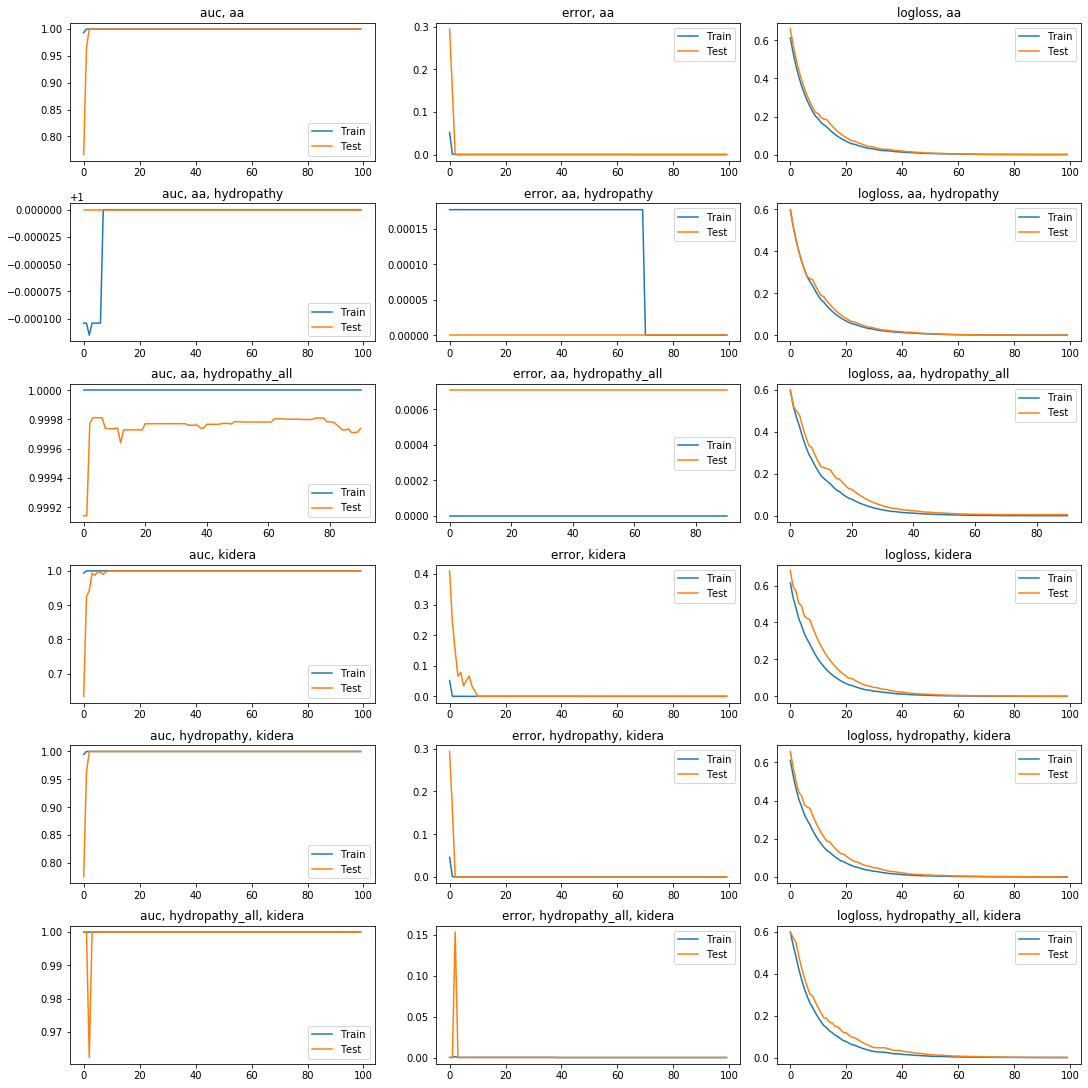

In [56]:
with_organism_plots(best_classifiers_org)

In [166]:
def lift(X_test, y_test, X_train, y_train, clf, title):
    plt.figure(figsize=(7, 4))

    y_test_pred = clf.predict_proba(X_test)[:, 1]
    arr1inds = y_test_pred.argsort()

    Z_sorted_test = y_test.iloc[arr1inds[::-1]]
    Z_split_test = np.array_split(np.array(Z_sorted_test), 25)
    
    y_train_pred = clf.predict_proba(X_train)[:, 1]
    arr1inds = y_train_pred.argsort()

    Z_sorted_train = y_train.iloc[arr1inds[::-1]]
    Z_split_train = np.array_split(np.array(Z_sorted_train), 25)
    
    
    
    test_means = []
    cnt = []
    c = 0
    for arr in Z_split_test:
        test_means.append(arr.mean())
        c += len(arr)
        cnt.append(c)
    plt.plot(test_means, label='Test')
    
    train_means = []
    cnt = []
    c = 0
    for arr in Z_split_train:
        train_means.append(arr.mean())
        c += len(arr)
        cnt.append(c)
    plt.plot(train_means, label='Train')
    
    plt.grid()
    plt.suptitle('Lift plot', size='xx-large')
#     plt.title(title)
    plt.xlabel('Cегмент')
    plt.legend(prop={'size': 18})
    plt.ylabel('Доля целевых событий')

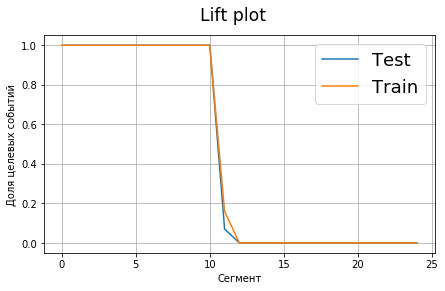

In [167]:
lift(best_clf_test_org[(False, True, False, True)][0], best_clf_test_org[(False, True, False, True)][1], 
     best_clf_train_org[(False, True, False, True)][0], best_clf_train_org[(False, True, False, True)][1], 
     best_classifiers_org[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, с организмом')

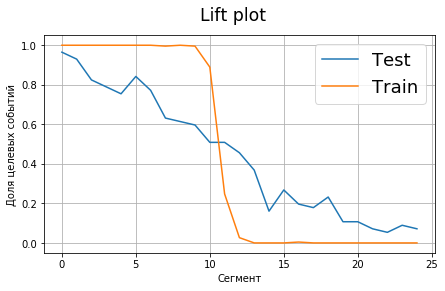

In [168]:
lift(best_clf_test[(False, True, False, True)][0], best_clf_test[(False, True, False, True)][1], 
     best_clf_train[(False, True, False, True)][0], best_clf_train[(False, True, False, True)][1], 
     best_classifiers[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, без организма')

In [159]:
def roc(X_test, y_test, X_train, y_train, clf, title):
    
    plt.figure(figsize=(7, 4))
    y_pred_test_org = clf.predict_proba(X_test)
    y_pred_train_org = clf.predict_proba(X_train)


    lr_fpr, lr_tpr, thresh = roc_curve(y_test, y_pred_test_org[:, 1])
    roc_auc = auc(lr_fpr, lr_tpr)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Test AUC = {roc_auc:.2f}')
    
    
    lr_fpr, lr_tpr, thresh = roc_curve(y_train, y_pred_train_org[:, 1])
    roc_auc = auc(lr_fpr, lr_tpr)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Train AUC = {roc_auc:.2f}')
    
    plt.legend(prop={'size': 18})
    plt.suptitle('ROC with AUC', fontsize='xx-large')
#     plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()

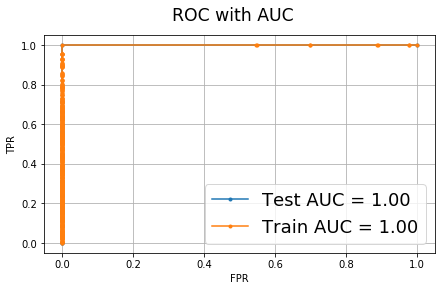

In [160]:
roc(best_clf_test_org[(False, True, False, True)][0], best_clf_test_org[(False, True, False, True)][1], 
    best_clf_train_org[(False, True, False, True)][0], best_clf_train_org[(False, True, False, True)][1], 
     best_classifiers_org[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, с организмом')


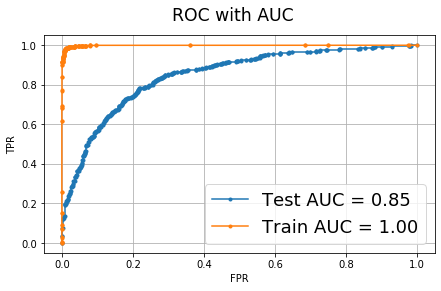

In [161]:
roc(best_clf_test[(False, True, False, True)][0], best_clf_test[(False, True, False, True)][1], 
    best_clf_train[(False, True, False, True)][0], best_clf_train[(False, True, False, True)][1], 
     best_classifiers[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, без организма')


In [163]:
def logloss(clf, title):
    plt.figure(figsize=(7, 4))
    ll_org_train = clf.evals_result()['validation_0']['logloss']
    ll_org_test = clf.evals_result()['validation_1']['logloss']
    plt.plot(ll_org_train, label='Train')
    plt.plot(ll_org_test, label='Test')
    vline = clf.best_iteration
    if vline:
        plt.axvline(vline)
    plt.grid()
    plt.legend(prop={'size': 18})
#     plt.title(title)
    plt.suptitle('LogLoss learning curves', size='xx-large')

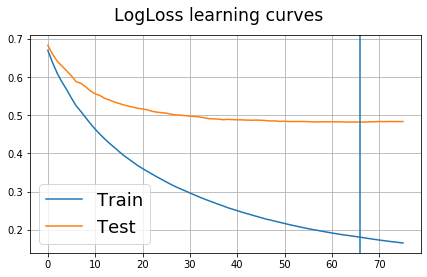

In [164]:
logloss(best_classifiers[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, без организма')


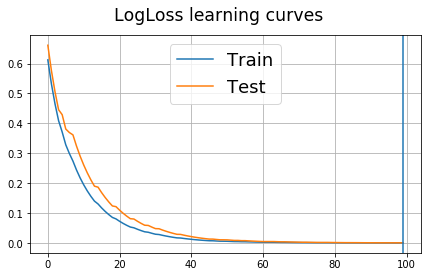

In [165]:
logloss(best_classifiers_org[(False, True, False, True)].best_estimator_, 
     'Kidera factors и уровень гидрофильности, с организмом')


In [143]:
def without_organism(dataset):
    feature_grid = [[True, False, False, False], [True, True, False, False], [True, False, True, False], 
                    [False, False, False, True], [False, True, False, True], [False, False, True, True]]

    param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.0005, 0.001, 0.01, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.4, 0.6, .8],
        'colsample_bylevel': [0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0],
        'gamma': [0, 0.25, 0.5],
        'reg_lambda': [0.1, 1.0, 5.0],
        'n_estimators': [20, 50, 150], 
        'reg_alpha': [0., 0.5, 0.9, 1.3],
        'num_parallel_tree': [1, 3]
    }

    best_classifiers = {}
    best_clf_test = {}
    best_clf_train = {}

    for features in feature_grid:
        df_train = prepare_data(dataset, *features)
        df_train.drop('Organism', inplace=True, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(df_train.drop('target', axis=1), df_train.target, 
                                                            test_size=0.2, stratify=df_train.target, shuffle=True)
        clf = xgb.XGBClassifier()



        random_search = RandomizedSearchCV(clf, param_grid, n_iter=60,
                                           n_jobs=-1, cv=3, scoring='neg_log_loss',
                                           verbose=3, random_state=42)

        random_search.fit(X_train, y_train, eval_metric=['auc', 'error', 'logloss'],
                      eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

        best_classifiers[tuple(features)] = random_search
        best_clf_test[tuple(features)] = [X_test, y_test]
        best_clf_train[tuple(features)] = [X_train, y_train]
    
    return best_classifiers, best_clf_test, best_clf_train

In [144]:
best_classifiers, best_clf_test, best_clf_train = without_organism(dataset)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.9s


[0]	validation_0-auc:0.882888	validation_0-error:0.193383	validation_0-logloss:0.660289	validation_1-auc:0.780825	validation_1-error:0.288543	validation_1-logloss:0.669763
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.894494	validation_0-error:0.182236	validation_0-logloss:0.62879	validation_1-auc:0.805266	validation_1-error:0.26662	validation_1-logloss:0.645986


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


[2]	validation_0-auc:0.897401	validation_0-error:0.176575	validation_0-logloss:0.602296	validation_1-auc:0.814417	validation_1-error:0.261669	validation_1-logloss:0.625914
[3]	validation_0-auc:0.899275	validation_0-error:0.174098	validation_0-logloss:0.578628	validation_1-auc:0.818249	validation_1-error:0.260962	validation_1-logloss:0.608666
[4]	validation_0-auc:0.902605	validation_0-error:0.174982	validation_0-logloss:0.557552	validation_1-auc:0.8191	validation_1-error:0.260255	validation_1-logloss:0.594844
[5]	validation_0-auc:0.907145	validation_0-error:0.167374	validation_0-logloss:0.538442	validation_1-auc:0.821076	validation_1-error:0.257426	validation_1-logloss:0.582734
[6]	validation_0-auc:0.910915	validation_0-error:0.164367	validation_0-logloss:0.522559	validation_1-auc:0.820963	validation_1-error:0.260255	validation_1-logloss:0.573701
[7]	validation_0-auc:0.914467	validation_0-error:0.16189	validation_0-logloss:0.507153	validation_1-auc:0.822832	validation_1-error:0.256011	v

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min


[0]	validation_0-auc:0.821628	validation_0-error:0.257077	validation_0-logloss:0.66823	validation_1-auc:0.74596	validation_1-error:0.316832	validation_1-logloss:0.673669
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.849103	validation_0-error:0.231069	validation_0-logloss:0.644986	validation_1-auc:0.783213	validation_1-error:0.292079	validation_1-logloss:0.653991
[2]	validation_0-auc:0.854183	validation_0-error:0.229476	validation_0-logloss:0.624924	validation_1-auc:0.78427	validation_1-error:0.283593	validation_1-logloss:0.638876
[3]	validation_0-auc:0.863349	validation_0-error:0.216207	validation_0-logloss:0.60559	validation_1-auc:0.792991	validation_1-error:0.282178	validation_1-logloss:0.624136
[4]	validation_0-auc:0.864521	validation_0-error:0.219214	validation_0-logloss:0.590541	validation_1-auc:0.792818	validation_1-error:0.287836	validatio

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


[5]	validation_0-auc:0.866927	validation_0-error:0.217799	validation_0-logloss:0.576685	validation_1-auc:0.791233	validation_1-error:0.287836	validation_1-logloss:0.60459
[6]	validation_0-auc:0.872691	validation_0-error:0.211253	validation_0-logloss:0.560825	validation_1-auc:0.798167	validation_1-error:0.274399	validation_1-logloss:0.592416
[7]	validation_0-auc:0.875596	validation_0-error:0.204883	validation_0-logloss:0.549061	validation_1-auc:0.80018	validation_1-error:0.277935	validation_1-logloss:0.584411
[8]	validation_0-auc:0.876757	validation_0-error:0.205237	validation_0-logloss:0.53916	validation_1-auc:0.800058	validation_1-error:0.278642	validation_1-logloss:0.578336
[9]	validation_0-auc:0.879411	validation_0-error:0.201522	validation_0-logloss:0.529921	validation_1-auc:0.802396	validation_1-error:0.276521	validation_1-logloss:0.57224
[10]	validation_0-auc:0.880152	validation_0-error:0.199929	validation_0-logloss:0.521696	validation_1-auc:0.803223	validation_1-error:0.280764	v

[53]	validation_0-auc:0.936435	validation_0-error:0.142074	validation_0-logloss:0.367047	validation_1-auc:0.829685	validation_1-error:0.253182	validation_1-logloss:0.504745
[54]	validation_0-auc:0.937493	validation_0-error:0.140481	validation_0-logloss:0.364997	validation_1-auc:0.829952	validation_1-error:0.251061	validation_1-logloss:0.504445
[55]	validation_0-auc:0.938163	validation_0-error:0.13995	validation_0-logloss:0.363241	validation_1-auc:0.830033	validation_1-error:0.251061	validation_1-logloss:0.504348
[56]	validation_0-auc:0.93943	validation_0-error:0.139243	validation_0-logloss:0.360941	validation_1-auc:0.830325	validation_1-error:0.248232	validation_1-logloss:0.50402
[57]	validation_0-auc:0.940389	validation_0-error:0.138889	validation_0-logloss:0.358884	validation_1-auc:0.830385	validation_1-error:0.247525	validation_1-logloss:0.503719
[58]	validation_0-auc:0.941214	validation_0-error:0.138535	validation_0-logloss:0.357083	validation_1-auc:0.830606	validation_1-error:0.24

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min


[0]	validation_0-auc:0.82263	validation_0-error:0.256546	validation_0-logloss:0.667202	validation_1-auc:0.76197	validation_1-error:0.299859	validation_1-logloss:0.672505
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.840005	validation_0-error:0.242569	validation_0-logloss:0.644819	validation_1-auc:0.773549	validation_1-error:0.294201	validation_1-logloss:0.655173
[2]	validation_0-auc:0.84702	validation_0-error:0.243277	validation_0-logloss:0.624739	validation_1-auc:0.776604	validation_1-error:0.286422	validation_1-logloss:0.64027
[3]	validation_0-auc:0.864308	validation_0-error:0.225407	validation_0-logloss:0.603798	validation_1-auc:0.794575	validation_1-error:0.280057	validation_1-logloss:0.623605


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.2min finished


[4]	validation_0-auc:0.870272	validation_0-error:0.219391	validation_0-logloss:0.586229	validation_1-auc:0.802622	validation_1-error:0.264498	validation_1-logloss:0.609711
[5]	validation_0-auc:0.87138	validation_0-error:0.219038	validation_0-logloss:0.572452	validation_1-auc:0.802098	validation_1-error:0.270156	validation_1-logloss:0.600559
[6]	validation_0-auc:0.877901	validation_0-error:0.20913	validation_0-logloss:0.556633	validation_1-auc:0.810677	validation_1-error:0.264498	validation_1-logloss:0.588026
[7]	validation_0-auc:0.880087	validation_0-error:0.206122	validation_0-logloss:0.54452	validation_1-auc:0.813458	validation_1-error:0.265205	validation_1-logloss:0.579112
[8]	validation_0-auc:0.883382	validation_0-error:0.199398	validation_0-logloss:0.531276	validation_1-auc:0.816625	validation_1-error:0.257426	validation_1-logloss:0.569323
[9]	validation_0-auc:0.885167	validation_0-error:0.197983	validation_0-logloss:0.521836	validation_1-auc:0.817613	validation_1-error:0.25884	va

[52]	validation_0-auc:0.948657	validation_0-error:0.128273	validation_0-logloss:0.348447	validation_1-auc:0.845707	validation_1-error:0.219943	validation_1-logloss:0.488771
[53]	validation_0-auc:0.949692	validation_0-error:0.126327	validation_0-logloss:0.346204	validation_1-auc:0.845972	validation_1-error:0.219236	validation_1-logloss:0.488369
[54]	validation_0-auc:0.950493	validation_0-error:0.125973	validation_0-logloss:0.344047	validation_1-auc:0.846221	validation_1-error:0.219236	validation_1-logloss:0.488021
[55]	validation_0-auc:0.951207	validation_0-error:0.124558	validation_0-logloss:0.34248	validation_1-auc:0.846397	validation_1-error:0.219236	validation_1-logloss:0.487703
[56]	validation_0-auc:0.951926	validation_0-error:0.12385	validation_0-logloss:0.340617	validation_1-auc:0.846598	validation_1-error:0.217822	validation_1-logloss:0.487533
[57]	validation_0-auc:0.952689	validation_0-error:0.121727	validation_0-logloss:0.338745	validation_1-auc:0.846555	validation_1-error:0.2

[100]	validation_0-auc:0.977012	validation_0-error:0.079972	validation_0-logloss:0.272723	validation_1-auc:0.850506	validation_1-error:0.217822	validation_1-logloss:0.4819
[101]	validation_0-auc:0.977598	validation_0-error:0.079264	validation_0-logloss:0.271147	validation_1-auc:0.850569	validation_1-error:0.218529	validation_1-logloss:0.481923
[102]	validation_0-auc:0.977925	validation_0-error:0.07891	validation_0-logloss:0.269842	validation_1-auc:0.850753	validation_1-error:0.218529	validation_1-logloss:0.481788
[103]	validation_0-auc:0.978499	validation_0-error:0.078379	validation_0-logloss:0.268178	validation_1-auc:0.850866	validation_1-error:0.219943	validation_1-logloss:0.48172
[104]	validation_0-auc:0.978876	validation_0-error:0.077849	validation_0-logloss:0.266956	validation_1-auc:0.850739	validation_1-error:0.219236	validation_1-logloss:0.481886
[105]	validation_0-auc:0.979328	validation_0-error:0.076433	validation_0-logloss:0.265575	validation_1-auc:0.850961	validation_1-error

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   56.7s


[0]	validation_0-auc:0.886735	validation_0-error:0.181352	validation_0-logloss:0.656151	validation_1-auc:0.814509	validation_1-error:0.260255	validation_1-logloss:0.664242
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.904249	validation_0-error:0.167197	validation_0-logloss:0.628419	validation_1-auc:0.830363	validation_1-error:0.244696	validation_1-logloss:0.642807


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


[2]	validation_0-auc:0.915302	validation_0-error:0.15552	validation_0-logloss:0.6024	validation_1-auc:0.834648	validation_1-error:0.241867	validation_1-logloss:0.624408
[3]	validation_0-auc:0.917336	validation_0-error:0.152512	validation_0-logloss:0.577356	validation_1-auc:0.838619	validation_1-error:0.229844	validation_1-logloss:0.605221
[4]	validation_0-auc:0.922113	validation_0-error:0.148797	validation_0-logloss:0.556534	validation_1-auc:0.840574	validation_1-error:0.234088	validation_1-logloss:0.590836
[5]	validation_0-auc:0.924867	validation_0-error:0.14632	validation_0-logloss:0.536833	validation_1-auc:0.841017	validation_1-error:0.239038	validation_1-logloss:0.577734
[6]	validation_0-auc:0.925385	validation_0-error:0.144904	validation_0-logloss:0.518736	validation_1-auc:0.841005	validation_1-error:0.239745	validation_1-logloss:0.565691
[7]	validation_0-auc:0.926727	validation_0-error:0.142074	validation_0-logloss:0.502451	validation_1-auc:0.842786	validation_1-error:0.239745	va

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.0min


[0]	validation_0-auc:0.827136	validation_0-error:0.19126	validation_0-logloss:0.669648	validation_1-auc:0.636158	validation_1-error:0.398161	validation_1-logloss:0.683175
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.907452	validation_0-error:0.16189	validation_0-logloss:0.637727	validation_1-auc:0.762258	validation_1-error:0.306931	validation_1-logloss:0.659838
[2]	validation_0-auc:0.925935	validation_0-error:0.141189	validation_0-logloss:0.609387	validation_1-auc:0.790472	validation_1-error:0.269448	validation_1-logloss:0.641167
[3]	validation_0-auc:0.934229	validation_0-error:0.130573	validation_0-logloss:0.586373	validation_1-auc:0.792714	validation_1-error:0.273692	validation_1-logloss:0.6285


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished


[4]	validation_0-auc:0.942687	validation_0-error:0.127565	validation_0-logloss:0.566653	validation_1-auc:0.80611	validation_1-error:0.257426	validation_1-logloss:0.615848
[5]	validation_0-auc:0.944756	validation_0-error:0.119781	validation_0-logloss:0.54453	validation_1-auc:0.810658	validation_1-error:0.258133	validation_1-logloss:0.602717
[6]	validation_0-auc:0.946025	validation_0-error:0.120311	validation_0-logloss:0.524238	validation_1-auc:0.820125	validation_1-error:0.250354	validation_1-logloss:0.587639
[7]	validation_0-auc:0.953742	validation_0-error:0.113942	validation_0-logloss:0.509404	validation_1-auc:0.818657	validation_1-error:0.24611	validation_1-logloss:0.5834
[8]	validation_0-auc:0.955668	validation_0-error:0.107396	validation_0-logloss:0.493431	validation_1-auc:0.821482	validation_1-error:0.248232	validation_1-logloss:0.574133
[9]	validation_0-auc:0.955248	validation_0-error:0.108103	validation_0-logloss:0.477871	validation_1-auc:0.826525	validation_1-error:0.248939	val

[52]	validation_0-auc:0.996843	validation_0-error:0.025124	validation_0-logloss:0.210578	validation_1-auc:0.846383	validation_1-error:0.223479	validation_1-logloss:0.48337
[53]	validation_0-auc:0.997084	validation_0-error:0.024239	validation_0-logloss:0.207939	validation_1-auc:0.846341	validation_1-error:0.222772	validation_1-logloss:0.483387
[54]	validation_0-auc:0.99731	validation_0-error:0.023178	validation_0-logloss:0.205336	validation_1-auc:0.846229	validation_1-error:0.223479	validation_1-logloss:0.483449
[55]	validation_0-auc:0.99753	validation_0-error:0.02247	validation_0-logloss:0.202747	validation_1-auc:0.846531	validation_1-error:0.224894	validation_1-logloss:0.483082
[56]	validation_0-auc:0.997684	validation_0-error:0.021762	validation_0-logloss:0.200302	validation_1-auc:0.846998	validation_1-error:0.227016	validation_1-logloss:0.482467
[57]	validation_0-auc:0.997771	validation_0-error:0.021762	validation_0-logloss:0.198164	validation_1-auc:0.847183	validation_1-error:0.227

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min


[0]	validation_0-auc:0.853885	validation_0-error:0.228769	validation_0-logloss:0.665234	validation_1-auc:0.808773	validation_1-error:0.270863	validation_1-logloss:0.669062
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.868383	validation_0-error:0.213907	validation_0-logloss:0.638971	validation_1-auc:0.825399	validation_1-error:0.256011	validation_1-logloss:0.646418
[2]	validation_0-auc:0.875389	validation_0-error:0.203468	validation_0-logloss:0.613403	validation_1-auc:0.830566	validation_1-error:0.250354	validation_1-logloss:0.62528
[3]	validation_0-auc:0.879305	validation_0-error:0.204352	validation_0-logloss:0.596035	validation_1-auc:0.831963	validation_1-error:0.255304	validation_1-logloss:0.611259


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


[4]	validation_0-auc:0.880843	validation_0-error:0.198868	validation_0-logloss:0.577015	validation_1-auc:0.835153	validation_1-error:0.248232	validation_1-logloss:0.595004
[5]	validation_0-auc:0.883597	validation_0-error:0.196037	validation_0-logloss:0.561025	validation_1-auc:0.836439	validation_1-error:0.243989	validation_1-logloss:0.58243
[6]	validation_0-auc:0.887555	validation_0-error:0.191967	validation_0-logloss:0.548478	validation_1-auc:0.838459	validation_1-error:0.243989	validation_1-logloss:0.573358
[7]	validation_0-auc:0.889685	validation_0-error:0.192321	validation_0-logloss:0.535894	validation_1-auc:0.839728	validation_1-error:0.247525	validation_1-logloss:0.564104
[8]	validation_0-auc:0.891669	validation_0-error:0.188606	validation_0-logloss:0.525807	validation_1-auc:0.839565	validation_1-error:0.247525	validation_1-logloss:0.557064
[9]	validation_0-auc:0.893701	validation_0-error:0.187721	validation_0-logloss:0.516869	validation_1-auc:0.840514	validation_1-error:0.247525

[52]	validation_0-auc:0.958824	validation_0-error:0.111996	validation_0-logloss:0.333671	validation_1-auc:0.85492	validation_1-error:0.234088	validation_1-logloss:0.474085
[53]	validation_0-auc:0.959608	validation_0-error:0.111465	validation_0-logloss:0.33129	validation_1-auc:0.855289	validation_1-error:0.234795	validation_1-logloss:0.473368
[54]	validation_0-auc:0.960124	validation_0-error:0.11058	validation_0-logloss:0.329791	validation_1-auc:0.854977	validation_1-error:0.234795	validation_1-logloss:0.473454
[55]	validation_0-auc:0.961046	validation_0-error:0.108103	validation_0-logloss:0.327778	validation_1-auc:0.854974	validation_1-error:0.235502	validation_1-logloss:0.473387
[56]	validation_0-auc:0.96187	validation_0-error:0.107396	validation_0-logloss:0.325456	validation_1-auc:0.855328	validation_1-error:0.230552	validation_1-logloss:0.472726
[57]	validation_0-auc:0.962469	validation_0-error:0.105626	validation_0-logloss:0.323496	validation_1-auc:0.85542	validation_1-error:0.2326

[100]	validation_0-auc:0.982992	validation_0-error:0.070241	validation_0-logloss:0.255968	validation_1-auc:0.858489	validation_1-error:0.236209	validation_1-logloss:0.463243
[101]	validation_0-auc:0.983249	validation_0-error:0.070241	validation_0-logloss:0.254718	validation_1-auc:0.858511	validation_1-error:0.236917	validation_1-logloss:0.463127
[102]	validation_0-auc:0.983562	validation_0-error:0.068825	validation_0-logloss:0.253641	validation_1-auc:0.858727	validation_1-error:0.236209	validation_1-logloss:0.462981
[103]	validation_0-auc:0.983979	validation_0-error:0.067941	validation_0-logloss:0.252193	validation_1-auc:0.858489	validation_1-error:0.236209	validation_1-logloss:0.463168
[104]	validation_0-auc:0.984178	validation_0-error:0.067233	validation_0-logloss:0.251127	validation_1-auc:0.858434	validation_1-error:0.235502	validation_1-logloss:0.463192
[105]	validation_0-auc:0.984507	validation_0-error:0.067056	validation_0-logloss:0.250018	validation_1-auc:0.858444	validation_1-e

In [59]:
def without_organism_plot(best_classifiers):
    # wo organism
    i = 0
    fig, axs = plt.subplots(6, 3, figsize=(15, 15), constrained_layout=True)


    for params in best_classifiers:
        current = best_classifiers[params].best_estimator_
        eval_results = current.evals_result()
        train_res = eval_results['validation_0']
        test_res = eval_results['validation_1']
        j = 0
        for metric in train_res:
            axs[i, j].plot(train_res[metric], label='Train')
            axs[i, j].plot(test_res[metric], label='Test')
            axs[i, j].axvline(current.best_iteration)
            axs[i, j].legend()
            axs[i, j].set_title(f'{metric}, {", ".join(params_str[list(params)])}')
            j += 1
        i += 1

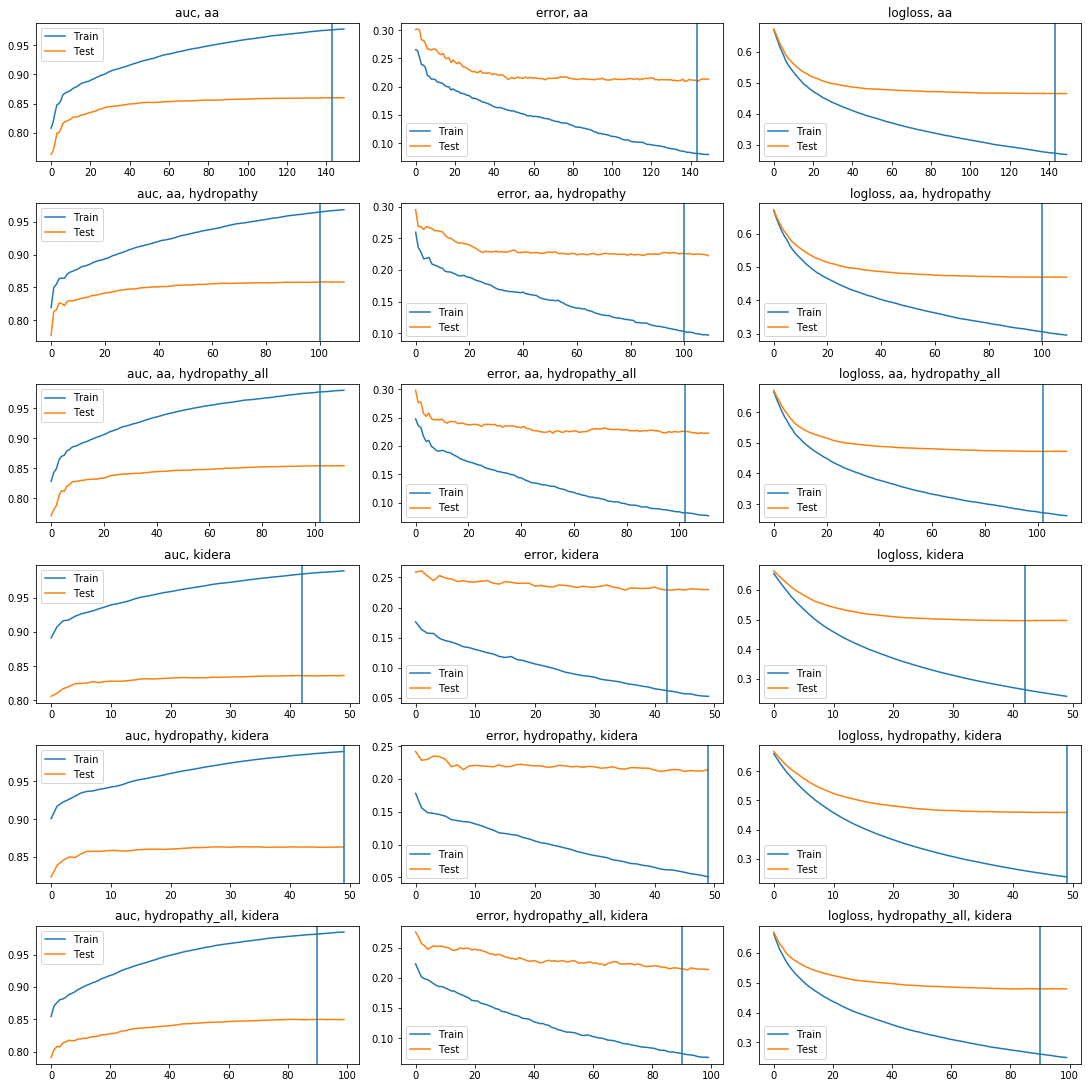

In [60]:
without_organism_plot(best_classifiers)

In [29]:
ll_org_train = best_classifiers_org[(True, False, False, False)].best_estimator_.evals_result()['validation_0']['logloss']
ll_org_test = best_classifiers_org[(True, False, False, False)].best_estimator_.evals_result()['validation_1']['logloss']


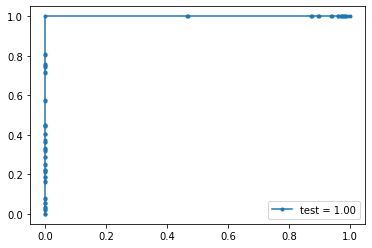

In [38]:
ll_train = best_classifiers[(True, False, False, False)].best_estimator_.evals_result()['validation_0']['logloss']
ll_test = best_classifiers[(True, False, False, False)].best_estimator_.evals_result()['validation_1']['logloss']


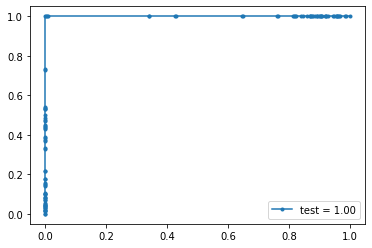

In [39]:
y_pred_test = best_classifiers[(True, False, False, False)].best_estimator_.predict_proba(best_clf_test[(True, False, False, False)][0])


lr_fpr, lr_tpr, thresh = roc_curve(best_clf_test[(True, False, False, False)][1], y_pred_test[:, 1])

roc_auc = auc(lr_fpr, lr_tpr)


plt.plot(lr_fpr, lr_tpr, marker='.', label=f'test = {roc_auc:.2f}')

plt.legend()


In [ ]:

### 
clf = xgb.XGBClassifier(max_depth=10, learning_rate=0.005, n_estimators=2000, n_jobs=-1, reg_lambda=3, 
                        reg_alpha=0.9, early_stopping_rounds=10)

clf.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'logloss', 'error'],
        verbose=True)

In [ ]:
evals_result = clf.evals_result()
print(clf.feature_importances_)
for metric in evals_result['validation_0'].keys():
    plt.plot(evals_result['validation_0'][metric], label=metric)
    plt.legend()
    plt.show()
    
y = clf.predict_proba(X_test)
lr_fpr, lr_tpr, thresh = roc_curve(y_test, y)

roc_auc = auc(lr_fpr, lr_tpr)


plt.plot(lr_fpr, lr_tpr, marker='.', label=f'test = {roc_auc:.2f}')

plt.legend()

In [131]:
# train function
# returns OOB score and AUCs for HLA-A and HLA-B

def train(df, random_seed, aa=True, hydropathy=False, hydropathy_all=False, kidera=False):
    
    print(f'Now running with parameters: random_seed={random_seed}, aa={aa}, hydropathy={hydropathy},'
          f' hydropathy_all={hydropathy_all}, kidera={kidera}')
    
    df_train = prepare_data(df, aa=aa, hydropathy=hydropathy, hydropathy_all=hydropathy_all, kidera=kidera)
    
    # making train - test split with stratification by target value and shuffling
    # TODO: set random state?

    X_train, X_test, y_train, y_test = train_test_split(df_train.drop('target', axis=1), df_train.target, 
                                                        test_size=0.3, stratify=df_train.target, shuffle=True, 
                                                        random_state=random_seed)
    
    idx_0 = X_test.loc[X_test.Allele == 0].index
    idx_1 = X_test.loc[X_test.Allele == 1].index
#     ind_rest = X_test.loc[~X_test.Allele.isin(0, 1)]
    
    X_test_0 = X_test.loc[idx_0]
    X_test_1 = X_test.loc[idx_1]
#     X_test_rest = X_test.loc[ind_rest]

    y_test_0 = y_test[idx_0]
    y_test_1 = y_test[idx_1]
    
    # scaling features. scaler is fitted on train data to prevent data leak
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test_0 = ss.fit_transform(X_test_0)
    X_test_1 = ss.fit_transform(X_test_1)
    X_test = ss.fit_transform(X_test)
    
    
    # random forest to try
    # TODO: boolean true?
    # no need in test set actually as oob scoring can be performed

    forest = RandomForestClassifier(n_estimators = 3500, max_depth = 15, max_features = 'sqrt', 
                                    bootstrap='True', n_jobs = -1, oob_score=True, min_samples_leaf=5, 
                                    min_samples_split=5, random_state=random_seed)
    # fitting with train data
    forest.fit(X_train, y_train)
    
    # too lazy to check on test
    # TODO: one day...
    print(f'OOB score = {forest.oob_score_}')
    
    # mapping feature names to scores

    feature_importance = {feature: importance for (feature, importance) in 
                          zip(df_train.drop('target', axis=1).columns, forest.feature_importances_)}
    
    # sorting in descending order
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    print('\nMost important features:')
    for feature in feature_importance[:4]:
        print(f'\t{feature[0]}: {feature[1]}')
    
    y_score_0 = forest.predict_proba(X_test_0)[:, 1]
    y_score_1 = forest.predict_proba(X_test_1)[:, 1]
    y_score = forest.predict_proba(X_test)[:, 1]

#     y_test = label_binarize(y_test, classes=[0, 1])
    lr_fpr_0, lr_tpr_0, _ = roc_curve(y_test_0, y_score_0)
    lr_fpr_1, lr_tpr_1, _ = roc_curve(y_test_1, y_score_1)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_score)

    roc_auc_0 = auc(lr_fpr_0, lr_tpr_0)
    roc_auc_1 = auc(lr_fpr_1, lr_tpr_1)
    roc_auc = auc(lr_fpr, lr_tpr)
    
    plt.plot(lr_fpr_0, lr_tpr_0, marker='.', label=f'HLA-A, AUC = {roc_auc_0:.2f}')
    plt.plot(lr_fpr_1, lr_tpr_1, marker='.', label=f'HLA-B, AUC = {roc_auc_1:.2f}')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'All, AUC = {roc_auc:.2f}')
    plt.legend()
    
    title = 'ROC, Kidera factors' if kidera else 'ROC, amino acid scores'
    if hydropathy_all:
        title += ' with all hydropathy features'
    elif hydropathy:
        title += ' with hydropathy feature'
    else:
        title += ' no hydropathy'
    plt.title(title)
    plt.show()
    print('\n\n')
    return [forest.oob_score_, roc_auc_0, roc_auc_1, roc_auc, X_train, X_test, y_train, y_test, forest]

Now running with parameters: random_seed=8085, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7682976142337242

Most important features:
	Allele: 0.1410477809147339
	polarity: 0.10331235566603951
	rim: 0.10330238189343922
	mjenergy: 0.0938759627299153


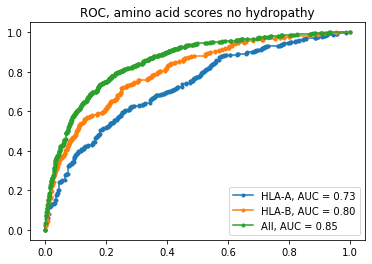

In [466]:
r = train(dataset, np.random.randint(0, 10000), True, False, False, False)

In [467]:
X_train, X_test, y_train, y_test, forest = r[4:]

In [468]:
forest = RandomForestClassifier(n_estimators = 350, max_depth = 15, max_features = 'sqrt', 
                                    
                                bootstrap='True',
                                n_jobs = -1, 
                                oob_score=True,
                                min_samples_leaf=5)

In [469]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
                       max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [470]:
forest.oob_score_

0.767691063485645

In [471]:
y = forest.predict_proba(X_test)[:, 1]
y_tr = forest.predict_proba(X_train)[:, 1]

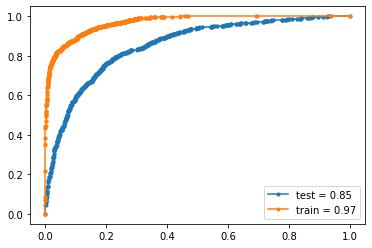

In [472]:
lr_fpr, lr_tpr, thresh = roc_curve(y_test, y)
lr_fpr_t, lr_tpr_t, _ = roc_curve(y_train, y_tr)
roc_auc = auc(lr_fpr, lr_tpr)
roc_auc_tr = auc(lr_fpr_t, lr_tpr_t)

plt.plot(lr_fpr, lr_tpr, marker='.', label=f'test = {roc_auc:.2f}')
plt.plot(lr_fpr_t, lr_tpr_t, marker='.', label=f'train = {roc_auc_tr:.2f}')
plt.legend()

In [473]:
optimal_idx = np.argmax(lr_tpr - lr_fpr)
optimal_threshold = thresh[optimal_idx]

In [474]:
optimal_threshold

0.4908662159116285

In [476]:
y >= optimal_threshold

array([False,  True,  True, ...,  True, False, False])

In [480]:
y_train.sum()

2208

In [590]:
random_search.fit(X_train, y_train, eval_metric=['logloss', 'auc', 'error'],
              eval_set=[(X_test, y_test)])

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 13.9min


[0]	validation_0-logloss:0.690392	validation_0-auc:0.785272	validation_0-error:0.284906
[1]	validation_0-logloss:0.687553	validation_0-auc:0.806173	validation_0-error:0.244811
[2]	validation_0-logloss:0.684724	validation_0-auc:0.821035	validation_0-error:0.241038
[3]	validation_0-logloss:0.682052	validation_0-auc:0.823364	validation_0-error:0.237264
[4]	validation_0-logloss:0.679562	validation_0-auc:0.824341	validation_0-error:0.239623
[5]	validation_0-logloss:0.676988	validation_0-auc:0.824742	validation_0-error:0.236792
[6]	validation_0-logloss:0.674419	validation_0-auc:0.824445	validation_0-error:0.238208
[7]	validation_0-logloss:0.671883	validation_0-auc:0.825394	validation_0-error:0.236321
[8]	validation_0-logloss:0.669264	validation_0-auc:0.827432	validation_0-error:0.237736
[9]	validation_0-logloss:0.666735	validation_0-auc:0.828673	validation_0-error:0.236792
[10]	validation_0-logloss:0.664241	validation_0-auc:0.829153	validation_0-error:0.234434
[11]	validation_0-logloss:0.661

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 17.1min finished


[24]	validation_0-logloss:0.634108	validation_0-auc:0.83092	validation_0-error:0.233019
[25]	validation_0-logloss:0.632152	validation_0-auc:0.831365	validation_0-error:0.232547
[26]	validation_0-logloss:0.630272	validation_0-auc:0.831511	validation_0-error:0.232547
[27]	validation_0-logloss:0.628342	validation_0-auc:0.831685	validation_0-error:0.232547
[28]	validation_0-logloss:0.626508	validation_0-auc:0.831618	validation_0-error:0.232075
[29]	validation_0-logloss:0.624883	validation_0-auc:0.831561	validation_0-error:0.234434
[30]	validation_0-logloss:0.623133	validation_0-auc:0.831424	validation_0-error:0.233491
[31]	validation_0-logloss:0.621461	validation_0-auc:0.831054	validation_0-error:0.231604
[32]	validation_0-logloss:0.619691	validation_0-auc:0.83126	validation_0-error:0.233019
[33]	validation_0-logloss:0.618186	validation_0-auc:0.830981	validation_0-error:0.234906
[34]	validation_0-logloss:0.616483	validation_0-auc:0.831185	validation_0-error:0.233019
[35]	validation_0-loglo

[117]	validation_0-logloss:0.534359	validation_0-auc:0.839704	validation_0-error:0.226887
[118]	validation_0-logloss:0.533832	validation_0-auc:0.839716	validation_0-error:0.228774
[119]	validation_0-logloss:0.533331	validation_0-auc:0.839772	validation_0-error:0.228774
[120]	validation_0-logloss:0.532721	validation_0-auc:0.839885	validation_0-error:0.229245
[121]	validation_0-logloss:0.53216	validation_0-auc:0.839969	validation_0-error:0.228302
[122]	validation_0-logloss:0.531655	validation_0-auc:0.840098	validation_0-error:0.228302
[123]	validation_0-logloss:0.531177	validation_0-auc:0.840179	validation_0-error:0.226887
[124]	validation_0-logloss:0.530653	validation_0-auc:0.840182	validation_0-error:0.227358
[125]	validation_0-logloss:0.530092	validation_0-auc:0.840293	validation_0-error:0.226415
[126]	validation_0-logloss:0.529541	validation_0-auc:0.840291	validation_0-error:0.228302
[127]	validation_0-logloss:0.52911	validation_0-auc:0.840276	validation_0-error:0.226887
[128]	valida

[209]	validation_0-logloss:0.500459	validation_0-auc:0.84762	validation_0-error:0.226415
[210]	validation_0-logloss:0.500189	validation_0-auc:0.847696	validation_0-error:0.226415
[211]	validation_0-logloss:0.49996	validation_0-auc:0.847762	validation_0-error:0.226415
[212]	validation_0-logloss:0.499782	validation_0-auc:0.847755	validation_0-error:0.22783
[213]	validation_0-logloss:0.49954	validation_0-auc:0.847831	validation_0-error:0.227358
[214]	validation_0-logloss:0.4994	validation_0-auc:0.847836	validation_0-error:0.226887
[215]	validation_0-logloss:0.499194	validation_0-auc:0.84789	validation_0-error:0.227358
[216]	validation_0-logloss:0.498994	validation_0-auc:0.84798	validation_0-error:0.22783
[217]	validation_0-logloss:0.498786	validation_0-auc:0.848004	validation_0-error:0.227358
[218]	validation_0-logloss:0.498576	validation_0-auc:0.848053	validation_0-error:0.226415
[219]	validation_0-logloss:0.498366	validation_0-auc:0.848111	validation_0-error:0.227358
[220]	validation_0-

[301]	validation_0-logloss:0.48557	validation_0-auc:0.852208	validation_0-error:0.224528
[302]	validation_0-logloss:0.485441	validation_0-auc:0.852256	validation_0-error:0.224057
[303]	validation_0-logloss:0.485344	validation_0-auc:0.852272	validation_0-error:0.224528
[304]	validation_0-logloss:0.485259	validation_0-auc:0.852336	validation_0-error:0.225
[305]	validation_0-logloss:0.485129	validation_0-auc:0.852357	validation_0-error:0.225
[306]	validation_0-logloss:0.485024	validation_0-auc:0.852382	validation_0-error:0.225
[307]	validation_0-logloss:0.484874	validation_0-auc:0.852437	validation_0-error:0.224057
[308]	validation_0-logloss:0.484764	validation_0-auc:0.852446	validation_0-error:0.224528
[309]	validation_0-logloss:0.484655	validation_0-auc:0.852479	validation_0-error:0.224057
[310]	validation_0-logloss:0.484521	validation_0-auc:0.852526	validation_0-error:0.223585
[311]	validation_0-logloss:0.484358	validation_0-auc:0.852572	validation_0-error:0.223113
[312]	validation_0-l

[393]	validation_0-logloss:0.476848	validation_0-auc:0.855705	validation_0-error:0.220283
[394]	validation_0-logloss:0.476776	validation_0-auc:0.855723	validation_0-error:0.219811
[395]	validation_0-logloss:0.476703	validation_0-auc:0.855791	validation_0-error:0.21934
[396]	validation_0-logloss:0.476613	validation_0-auc:0.855794	validation_0-error:0.21934
[397]	validation_0-logloss:0.476518	validation_0-auc:0.855868	validation_0-error:0.219811
[398]	validation_0-logloss:0.47641	validation_0-auc:0.855952	validation_0-error:0.220283
[399]	validation_0-logloss:0.476325	validation_0-auc:0.855988	validation_0-error:0.21934
[400]	validation_0-logloss:0.476247	validation_0-auc:0.856051	validation_0-error:0.21934
[401]	validation_0-logloss:0.476167	validation_0-auc:0.856106	validation_0-error:0.21934
[402]	validation_0-logloss:0.476079	validation_0-auc:0.856123	validation_0-error:0.21934
[403]	validation_0-logloss:0.476024	validation_0-auc:0.856153	validation_0-error:0.21934
[404]	validation_0

[485]	validation_0-logloss:0.471589	validation_0-auc:0.858268	validation_0-error:0.217453
[486]	validation_0-logloss:0.471556	validation_0-auc:0.858283	validation_0-error:0.217453
[487]	validation_0-logloss:0.471574	validation_0-auc:0.858207	validation_0-error:0.217925
[488]	validation_0-logloss:0.471558	validation_0-auc:0.858214	validation_0-error:0.217925
[489]	validation_0-logloss:0.471427	validation_0-auc:0.858293	validation_0-error:0.218396
[490]	validation_0-logloss:0.471388	validation_0-auc:0.858306	validation_0-error:0.217925
[491]	validation_0-logloss:0.471355	validation_0-auc:0.858342	validation_0-error:0.217453
[492]	validation_0-logloss:0.471223	validation_0-auc:0.858415	validation_0-error:0.217453
[493]	validation_0-logloss:0.471185	validation_0-auc:0.858438	validation_0-error:0.217453
[494]	validation_0-logloss:0.471123	validation_0-auc:0.858474	validation_0-error:0.217925
[495]	validation_0-logloss:0.471067	validation_0-auc:0.858487	validation_0-error:0.217925
[496]	vali

[577]	validation_0-logloss:0.46832	validation_0-auc:0.859542	validation_0-error:0.214151
[578]	validation_0-logloss:0.468258	validation_0-auc:0.859605	validation_0-error:0.214623
[579]	validation_0-logloss:0.468173	validation_0-auc:0.859657	validation_0-error:0.214151
[580]	validation_0-logloss:0.468208	validation_0-auc:0.859601	validation_0-error:0.214623
[581]	validation_0-logloss:0.468169	validation_0-auc:0.859619	validation_0-error:0.214623
[582]	validation_0-logloss:0.468118	validation_0-auc:0.859646	validation_0-error:0.214623
[583]	validation_0-logloss:0.468114	validation_0-auc:0.85963	validation_0-error:0.214151
[584]	validation_0-logloss:0.468085	validation_0-auc:0.859648	validation_0-error:0.214151
[585]	validation_0-logloss:0.468047	validation_0-auc:0.859672	validation_0-error:0.213679
[586]	validation_0-logloss:0.467978	validation_0-auc:0.859725	validation_0-error:0.213679
[587]	validation_0-logloss:0.46793	validation_0-auc:0.859723	validation_0-error:0.213679
[588]	validat

[669]	validation_0-logloss:0.466491	validation_0-auc:0.860226	validation_0-error:0.212736
[670]	validation_0-logloss:0.466485	validation_0-auc:0.860227	validation_0-error:0.212264
[671]	validation_0-logloss:0.466464	validation_0-auc:0.86025	validation_0-error:0.212264
[672]	validation_0-logloss:0.466457	validation_0-auc:0.860228	validation_0-error:0.212264
[673]	validation_0-logloss:0.466464	validation_0-auc:0.860215	validation_0-error:0.212264
[674]	validation_0-logloss:0.466452	validation_0-auc:0.860221	validation_0-error:0.212264
[675]	validation_0-logloss:0.46642	validation_0-auc:0.860217	validation_0-error:0.212264
[676]	validation_0-logloss:0.466413	validation_0-auc:0.860197	validation_0-error:0.211792
[677]	validation_0-logloss:0.466395	validation_0-auc:0.860226	validation_0-error:0.211792
[678]	validation_0-logloss:0.4664	validation_0-auc:0.860185	validation_0-error:0.211321
[679]	validation_0-logloss:0.466406	validation_0-auc:0.860188	validation_0-error:0.211321
[680]	validati

[761]	validation_0-logloss:0.465453	validation_0-auc:0.860731	validation_0-error:0.209434
[762]	validation_0-logloss:0.465452	validation_0-auc:0.860721	validation_0-error:0.209434
[763]	validation_0-logloss:0.465464	validation_0-auc:0.860678	validation_0-error:0.208491
[764]	validation_0-logloss:0.465451	validation_0-auc:0.86069	validation_0-error:0.208962
[765]	validation_0-logloss:0.465423	validation_0-auc:0.860687	validation_0-error:0.208491
[766]	validation_0-logloss:0.46541	validation_0-auc:0.860701	validation_0-error:0.208019
[767]	validation_0-logloss:0.465371	validation_0-auc:0.860709	validation_0-error:0.208019
[768]	validation_0-logloss:0.465364	validation_0-auc:0.860737	validation_0-error:0.208019
[769]	validation_0-logloss:0.465392	validation_0-auc:0.8607	validation_0-error:0.208019
[770]	validation_0-logloss:0.465394	validation_0-auc:0.860685	validation_0-error:0.208019
[771]	validation_0-logloss:0.465383	validation_0-auc:0.860723	validation_0-error:0.208019
[772]	validati

[853]	validation_0-logloss:0.464567	validation_0-auc:0.861072	validation_0-error:0.206604
[854]	validation_0-logloss:0.464541	validation_0-auc:0.861087	validation_0-error:0.207075
[855]	validation_0-logloss:0.464531	validation_0-auc:0.861091	validation_0-error:0.207075
[856]	validation_0-logloss:0.464541	validation_0-auc:0.861066	validation_0-error:0.207547
[857]	validation_0-logloss:0.464494	validation_0-auc:0.861106	validation_0-error:0.207547
[858]	validation_0-logloss:0.464464	validation_0-auc:0.861131	validation_0-error:0.207547
[859]	validation_0-logloss:0.464446	validation_0-auc:0.861136	validation_0-error:0.206604
[860]	validation_0-logloss:0.464496	validation_0-auc:0.861084	validation_0-error:0.206604
[861]	validation_0-logloss:0.464516	validation_0-auc:0.86104	validation_0-error:0.206132
[862]	validation_0-logloss:0.464543	validation_0-auc:0.861043	validation_0-error:0.206132
[863]	validation_0-logloss:0.464524	validation_0-auc:0.861047	validation_0-error:0.206132
[864]	valid

[945]	validation_0-logloss:0.464591	validation_0-auc:0.860896	validation_0-error:0.209434
[946]	validation_0-logloss:0.464585	validation_0-auc:0.860883	validation_0-error:0.209434
[947]	validation_0-logloss:0.464621	validation_0-auc:0.860874	validation_0-error:0.209434
[948]	validation_0-logloss:0.464645	validation_0-auc:0.860858	validation_0-error:0.209434
[949]	validation_0-logloss:0.464601	validation_0-auc:0.860858	validation_0-error:0.209906
[950]	validation_0-logloss:0.464613	validation_0-auc:0.860868	validation_0-error:0.209906
[951]	validation_0-logloss:0.464592	validation_0-auc:0.860854	validation_0-error:0.209906
[952]	validation_0-logloss:0.464558	validation_0-auc:0.860863	validation_0-error:0.209906
[953]	validation_0-logloss:0.46456	validation_0-auc:0.860856	validation_0-error:0.209906
[954]	validation_0-logloss:0.464582	validation_0-auc:0.860864	validation_0-error:0.208962
[955]	validation_0-logloss:0.464568	validation_0-auc:0.860899	validation_0-error:0.209434
[956]	valid

[1036]	validation_0-logloss:0.464994	validation_0-auc:0.860594	validation_0-error:0.208019
[1037]	validation_0-logloss:0.465015	validation_0-auc:0.860598	validation_0-error:0.206604
[1038]	validation_0-logloss:0.465008	validation_0-auc:0.860609	validation_0-error:0.207075
[1039]	validation_0-logloss:0.465	validation_0-auc:0.8606	validation_0-error:0.206604
[1040]	validation_0-logloss:0.465043	validation_0-auc:0.86058	validation_0-error:0.207075
[1041]	validation_0-logloss:0.465059	validation_0-auc:0.860562	validation_0-error:0.208019
[1042]	validation_0-logloss:0.46506	validation_0-auc:0.860531	validation_0-error:0.206604
[1043]	validation_0-logloss:0.465073	validation_0-auc:0.86054	validation_0-error:0.207075
[1044]	validation_0-logloss:0.4651	validation_0-auc:0.860542	validation_0-error:0.207075
[1045]	validation_0-logloss:0.465067	validation_0-auc:0.860538	validation_0-error:0.207075
[1046]	validation_0-logloss:0.465053	validation_0-auc:0.860549	validation_0-error:0.207075
[1047]	va

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                        'max_depth': [6, 10, 15, 20],
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0]

In [591]:
best_for_aa_only = random_search

In [577]:
clf.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'logloss', 'error'],
        verbose=True)

[0]	validation_0-auc:0.812795	validation_0-logloss:0.691496	validation_0-error:0.260849
[1]	validation_0-auc:0.812477	validation_0-logloss:0.689872	validation_0-error:0.260849
[2]	validation_0-auc:0.81364	validation_0-logloss:0.688266	validation_0-error:0.261792
[3]	validation_0-auc:0.815442	validation_0-logloss:0.68667	validation_0-error:0.255189
[4]	validation_0-auc:0.816806	validation_0-logloss:0.685099	validation_0-error:0.253774
[5]	validation_0-auc:0.817527	validation_0-logloss:0.683547	validation_0-error:0.251415
[6]	validation_0-auc:0.81769	validation_0-logloss:0.682006	validation_0-error:0.247642
[7]	validation_0-auc:0.820592	validation_0-logloss:0.680471	validation_0-error:0.247642
[8]	validation_0-auc:0.820115	validation_0-logloss:0.678971	validation_0-error:0.245283
[9]	validation_0-auc:0.82174	validation_0-logloss:0.677469	validation_0-error:0.246698
[10]	validation_0-auc:0.822607	validation_0-logloss:0.675986	validation_0-error:0.24434
[11]	validation_0-auc:0.822193	valid

[93]	validation_0-auc:0.834027	validation_0-logloss:0.589196	validation_0-error:0.232075
[94]	validation_0-auc:0.834009	validation_0-logloss:0.588487	validation_0-error:0.233491
[95]	validation_0-auc:0.83416	validation_0-logloss:0.587759	validation_0-error:0.232075
[96]	validation_0-auc:0.834197	validation_0-logloss:0.587054	validation_0-error:0.231132
[97]	validation_0-auc:0.834267	validation_0-logloss:0.586325	validation_0-error:0.231132
[98]	validation_0-auc:0.834302	validation_0-logloss:0.585626	validation_0-error:0.231604
[99]	validation_0-auc:0.834469	validation_0-logloss:0.584914	validation_0-error:0.230189
[100]	validation_0-auc:0.834541	validation_0-logloss:0.584196	validation_0-error:0.230189
[101]	validation_0-auc:0.834581	validation_0-logloss:0.583489	validation_0-error:0.229245
[102]	validation_0-auc:0.834739	validation_0-logloss:0.582771	validation_0-error:0.229717
[103]	validation_0-auc:0.834758	validation_0-logloss:0.582094	validation_0-error:0.229717
[104]	validation_0

[185]	validation_0-auc:0.837642	validation_0-logloss:0.540322	validation_0-error:0.231604
[186]	validation_0-auc:0.837723	validation_0-logloss:0.539927	validation_0-error:0.232075
[187]	validation_0-auc:0.837818	validation_0-logloss:0.539529	validation_0-error:0.232075
[188]	validation_0-auc:0.837792	validation_0-logloss:0.539186	validation_0-error:0.231604
[189]	validation_0-auc:0.837878	validation_0-logloss:0.538761	validation_0-error:0.231604
[190]	validation_0-auc:0.837957	validation_0-logloss:0.538353	validation_0-error:0.232075
[191]	validation_0-auc:0.837939	validation_0-logloss:0.538048	validation_0-error:0.231604
[192]	validation_0-auc:0.837985	validation_0-logloss:0.537642	validation_0-error:0.231132
[193]	validation_0-auc:0.838098	validation_0-logloss:0.53723	validation_0-error:0.231604
[194]	validation_0-auc:0.838117	validation_0-logloss:0.536893	validation_0-error:0.232547
[195]	validation_0-auc:0.838144	validation_0-logloss:0.536556	validation_0-error:0.232075
[196]	valid

[277]	validation_0-auc:0.842643	validation_0-logloss:0.512913	validation_0-error:0.226887
[278]	validation_0-auc:0.842701	validation_0-logloss:0.512674	validation_0-error:0.227358
[279]	validation_0-auc:0.842792	validation_0-logloss:0.512416	validation_0-error:0.226887
[280]	validation_0-auc:0.842857	validation_0-logloss:0.512177	validation_0-error:0.227358
[281]	validation_0-auc:0.842921	validation_0-logloss:0.511942	validation_0-error:0.22783
[282]	validation_0-auc:0.843006	validation_0-logloss:0.511686	validation_0-error:0.226887
[283]	validation_0-auc:0.843052	validation_0-logloss:0.511457	validation_0-error:0.227358
[284]	validation_0-auc:0.84312	validation_0-logloss:0.511231	validation_0-error:0.228774
[285]	validation_0-auc:0.843192	validation_0-logloss:0.510982	validation_0-error:0.229245
[286]	validation_0-auc:0.843231	validation_0-logloss:0.510763	validation_0-error:0.229245
[287]	validation_0-auc:0.843296	validation_0-logloss:0.510541	validation_0-error:0.229717
[288]	valida

[369]	validation_0-auc:0.845755	validation_0-logloss:0.497622	validation_0-error:0.225943
[370]	validation_0-auc:0.845775	validation_0-logloss:0.497542	validation_0-error:0.225943
[371]	validation_0-auc:0.845797	validation_0-logloss:0.497403	validation_0-error:0.225943
[372]	validation_0-auc:0.845801	validation_0-logloss:0.497302	validation_0-error:0.226415
[373]	validation_0-auc:0.845819	validation_0-logloss:0.49717	validation_0-error:0.226415
[374]	validation_0-auc:0.845806	validation_0-logloss:0.497052	validation_0-error:0.226415
[375]	validation_0-auc:0.845843	validation_0-logloss:0.496954	validation_0-error:0.226415
[376]	validation_0-auc:0.845856	validation_0-logloss:0.496881	validation_0-error:0.226415
[377]	validation_0-auc:0.845894	validation_0-logloss:0.496759	validation_0-error:0.225943
[378]	validation_0-auc:0.845863	validation_0-logloss:0.496677	validation_0-error:0.225943
[379]	validation_0-auc:0.845867	validation_0-logloss:0.496571	validation_0-error:0.226415
[380]	valid

[461]	validation_0-auc:0.848464	validation_0-logloss:0.48802	validation_0-error:0.222642
[462]	validation_0-auc:0.848468	validation_0-logloss:0.487931	validation_0-error:0.222642
[463]	validation_0-auc:0.848546	validation_0-logloss:0.48783	validation_0-error:0.22217
[464]	validation_0-auc:0.848571	validation_0-logloss:0.487759	validation_0-error:0.221698
[465]	validation_0-auc:0.848589	validation_0-logloss:0.487687	validation_0-error:0.221698
[466]	validation_0-auc:0.848612	validation_0-logloss:0.487597	validation_0-error:0.221698
[467]	validation_0-auc:0.848654	validation_0-logloss:0.487502	validation_0-error:0.221698
[468]	validation_0-auc:0.848697	validation_0-logloss:0.487423	validation_0-error:0.221698
[469]	validation_0-auc:0.848716	validation_0-logloss:0.48735	validation_0-error:0.221698
[470]	validation_0-auc:0.848714	validation_0-logloss:0.487267	validation_0-error:0.22217
[471]	validation_0-auc:0.848755	validation_0-logloss:0.487179	validation_0-error:0.221226
[472]	validatio

[553]	validation_0-auc:0.850997	validation_0-logloss:0.481572	validation_0-error:0.217453
[554]	validation_0-auc:0.851036	validation_0-logloss:0.481493	validation_0-error:0.217453
[555]	validation_0-auc:0.851088	validation_0-logloss:0.481397	validation_0-error:0.217925
[556]	validation_0-auc:0.851133	validation_0-logloss:0.481326	validation_0-error:0.217925
[557]	validation_0-auc:0.851116	validation_0-logloss:0.481296	validation_0-error:0.217453
[558]	validation_0-auc:0.851168	validation_0-logloss:0.481226	validation_0-error:0.217453
[559]	validation_0-auc:0.851144	validation_0-logloss:0.481205	validation_0-error:0.216981
[560]	validation_0-auc:0.851177	validation_0-logloss:0.48115	validation_0-error:0.216981
[561]	validation_0-auc:0.851175	validation_0-logloss:0.481127	validation_0-error:0.217453
[562]	validation_0-auc:0.851226	validation_0-logloss:0.481069	validation_0-error:0.217925
[563]	validation_0-auc:0.851246	validation_0-logloss:0.481008	validation_0-error:0.216981
[564]	valid

[645]	validation_0-auc:0.852525	validation_0-logloss:0.477702	validation_0-error:0.216981
[646]	validation_0-auc:0.852555	validation_0-logloss:0.477654	validation_0-error:0.216981
[647]	validation_0-auc:0.852557	validation_0-logloss:0.477615	validation_0-error:0.217453
[648]	validation_0-auc:0.852582	validation_0-logloss:0.477567	validation_0-error:0.217453
[649]	validation_0-auc:0.852612	validation_0-logloss:0.477501	validation_0-error:0.216981
[650]	validation_0-auc:0.852613	validation_0-logloss:0.477475	validation_0-error:0.217453
[651]	validation_0-auc:0.852625	validation_0-logloss:0.477437	validation_0-error:0.217453
[652]	validation_0-auc:0.852659	validation_0-logloss:0.477424	validation_0-error:0.217453
[653]	validation_0-auc:0.852703	validation_0-logloss:0.477392	validation_0-error:0.216981
[654]	validation_0-auc:0.852685	validation_0-logloss:0.477345	validation_0-error:0.216981
[655]	validation_0-auc:0.852716	validation_0-logloss:0.477292	validation_0-error:0.216509
[656]	vali

[737]	validation_0-auc:0.854179	validation_0-logloss:0.474429	validation_0-error:0.21934
[738]	validation_0-auc:0.854177	validation_0-logloss:0.474404	validation_0-error:0.21934
[739]	validation_0-auc:0.854173	validation_0-logloss:0.474386	validation_0-error:0.219811
[740]	validation_0-auc:0.854202	validation_0-logloss:0.474352	validation_0-error:0.218868
[741]	validation_0-auc:0.854209	validation_0-logloss:0.474315	validation_0-error:0.218868
[742]	validation_0-auc:0.854197	validation_0-logloss:0.474298	validation_0-error:0.21934
[743]	validation_0-auc:0.854211	validation_0-logloss:0.474267	validation_0-error:0.218868
[744]	validation_0-auc:0.854247	validation_0-logloss:0.47423	validation_0-error:0.218868
[745]	validation_0-auc:0.854271	validation_0-logloss:0.474194	validation_0-error:0.218396
[746]	validation_0-auc:0.854274	validation_0-logloss:0.474177	validation_0-error:0.218868
[747]	validation_0-auc:0.854311	validation_0-logloss:0.474137	validation_0-error:0.218396
[748]	validati

[829]	validation_0-auc:0.855304	validation_0-logloss:0.472306	validation_0-error:0.214623
[830]	validation_0-auc:0.85532	validation_0-logloss:0.472286	validation_0-error:0.215566
[831]	validation_0-auc:0.855333	validation_0-logloss:0.47227	validation_0-error:0.216038
[832]	validation_0-auc:0.855343	validation_0-logloss:0.472245	validation_0-error:0.215094
[833]	validation_0-auc:0.855352	validation_0-logloss:0.472246	validation_0-error:0.216038
[834]	validation_0-auc:0.855343	validation_0-logloss:0.472227	validation_0-error:0.215566
[835]	validation_0-auc:0.855357	validation_0-logloss:0.472217	validation_0-error:0.216038
[836]	validation_0-auc:0.855382	validation_0-logloss:0.472185	validation_0-error:0.216509
[837]	validation_0-auc:0.855388	validation_0-logloss:0.472168	validation_0-error:0.215566
[838]	validation_0-auc:0.85539	validation_0-logloss:0.472144	validation_0-error:0.216038
[839]	validation_0-auc:0.855392	validation_0-logloss:0.472137	validation_0-error:0.216038
[840]	validat

[921]	validation_0-auc:0.855812	validation_0-logloss:0.471131	validation_0-error:0.216981
[922]	validation_0-auc:0.855812	validation_0-logloss:0.471126	validation_0-error:0.216981
[923]	validation_0-auc:0.855815	validation_0-logloss:0.471142	validation_0-error:0.217453
[924]	validation_0-auc:0.855833	validation_0-logloss:0.471117	validation_0-error:0.216509
[925]	validation_0-auc:0.855837	validation_0-logloss:0.471099	validation_0-error:0.216509
[926]	validation_0-auc:0.855821	validation_0-logloss:0.471093	validation_0-error:0.216509
[927]	validation_0-auc:0.855847	validation_0-logloss:0.471065	validation_0-error:0.216509
[928]	validation_0-auc:0.855857	validation_0-logloss:0.471057	validation_0-error:0.216509
[929]	validation_0-auc:0.855894	validation_0-logloss:0.471018	validation_0-error:0.216509
[930]	validation_0-auc:0.855904	validation_0-logloss:0.471009	validation_0-error:0.216981
[931]	validation_0-auc:0.855905	validation_0-logloss:0.470995	validation_0-error:0.217453
[932]	vali

[1013]	validation_0-auc:0.855917	validation_0-logloss:0.470777	validation_0-error:0.218868
[1014]	validation_0-auc:0.855952	validation_0-logloss:0.470752	validation_0-error:0.218396
[1015]	validation_0-auc:0.855939	validation_0-logloss:0.470757	validation_0-error:0.21934
[1016]	validation_0-auc:0.855947	validation_0-logloss:0.470746	validation_0-error:0.21934
[1017]	validation_0-auc:0.85595	validation_0-logloss:0.470744	validation_0-error:0.218868
[1018]	validation_0-auc:0.855928	validation_0-logloss:0.470755	validation_0-error:0.218396
[1019]	validation_0-auc:0.855942	validation_0-logloss:0.470735	validation_0-error:0.218396
[1020]	validation_0-auc:0.855942	validation_0-logloss:0.47073	validation_0-error:0.218396
[1021]	validation_0-auc:0.855951	validation_0-logloss:0.470736	validation_0-error:0.218868
[1022]	validation_0-auc:0.85594	validation_0-logloss:0.47075	validation_0-error:0.218868
[1023]	validation_0-auc:0.855947	validation_0-logloss:0.470762	validation_0-error:0.218868
[1024

[1104]	validation_0-auc:0.856289	validation_0-logloss:0.470405	validation_0-error:0.21934
[1105]	validation_0-auc:0.85632	validation_0-logloss:0.470385	validation_0-error:0.21934
[1106]	validation_0-auc:0.856313	validation_0-logloss:0.470387	validation_0-error:0.218868
[1107]	validation_0-auc:0.856309	validation_0-logloss:0.470397	validation_0-error:0.218868
[1108]	validation_0-auc:0.856328	validation_0-logloss:0.470407	validation_0-error:0.218868
[1109]	validation_0-auc:0.856339	validation_0-logloss:0.470398	validation_0-error:0.218868
[1110]	validation_0-auc:0.856326	validation_0-logloss:0.470414	validation_0-error:0.218868
[1111]	validation_0-auc:0.856332	validation_0-logloss:0.470421	validation_0-error:0.218868
[1112]	validation_0-auc:0.856347	validation_0-logloss:0.470419	validation_0-error:0.218868
[1113]	validation_0-auc:0.856348	validation_0-logloss:0.470419	validation_0-error:0.218868
[1114]	validation_0-auc:0.856334	validation_0-logloss:0.470434	validation_0-error:0.218868
[1

[1195]	validation_0-auc:0.856283	validation_0-logloss:0.470801	validation_0-error:0.218396
[1196]	validation_0-auc:0.856295	validation_0-logloss:0.470795	validation_0-error:0.21934
[1197]	validation_0-auc:0.856319	validation_0-logloss:0.470799	validation_0-error:0.21934
[1198]	validation_0-auc:0.85632	validation_0-logloss:0.470793	validation_0-error:0.218868
[1199]	validation_0-auc:0.8563	validation_0-logloss:0.470786	validation_0-error:0.21934
[1200]	validation_0-auc:0.856335	validation_0-logloss:0.470785	validation_0-error:0.218868
[1201]	validation_0-auc:0.856326	validation_0-logloss:0.470795	validation_0-error:0.218868
[1202]	validation_0-auc:0.856326	validation_0-logloss:0.470794	validation_0-error:0.21934
[1203]	validation_0-auc:0.85634	validation_0-logloss:0.470797	validation_0-error:0.21934
[1204]	validation_0-auc:0.856347	validation_0-logloss:0.470798	validation_0-error:0.219811
[1205]	validation_0-auc:0.856361	validation_0-logloss:0.470793	validation_0-error:0.21934
[1206]	va

[1286]	validation_0-auc:0.856277	validation_0-logloss:0.471076	validation_0-error:0.220755
[1287]	validation_0-auc:0.856264	validation_0-logloss:0.471091	validation_0-error:0.220755
[1288]	validation_0-auc:0.856277	validation_0-logloss:0.471094	validation_0-error:0.220755
[1289]	validation_0-auc:0.856284	validation_0-logloss:0.471089	validation_0-error:0.220755
[1290]	validation_0-auc:0.856283	validation_0-logloss:0.4711	validation_0-error:0.220755
[1291]	validation_0-auc:0.856267	validation_0-logloss:0.471117	validation_0-error:0.220755
[1292]	validation_0-auc:0.856273	validation_0-logloss:0.471109	validation_0-error:0.221698
[1293]	validation_0-auc:0.856274	validation_0-logloss:0.471116	validation_0-error:0.221698
[1294]	validation_0-auc:0.856252	validation_0-logloss:0.471132	validation_0-error:0.221698
[1295]	validation_0-auc:0.856263	validation_0-logloss:0.471133	validation_0-error:0.22217
[1296]	validation_0-auc:0.856262	validation_0-logloss:0.471137	validation_0-error:0.22217
[12

[1377]	validation_0-auc:0.856335	validation_0-logloss:0.471326	validation_0-error:0.221226
[1378]	validation_0-auc:0.856347	validation_0-logloss:0.471325	validation_0-error:0.221226
[1379]	validation_0-auc:0.856345	validation_0-logloss:0.471321	validation_0-error:0.221226
[1380]	validation_0-auc:0.856349	validation_0-logloss:0.47133	validation_0-error:0.221698
[1381]	validation_0-auc:0.856344	validation_0-logloss:0.471327	validation_0-error:0.221226
[1382]	validation_0-auc:0.856338	validation_0-logloss:0.471337	validation_0-error:0.221226
[1383]	validation_0-auc:0.856345	validation_0-logloss:0.471352	validation_0-error:0.221226
[1384]	validation_0-auc:0.856352	validation_0-logloss:0.471357	validation_0-error:0.221226
[1385]	validation_0-auc:0.856344	validation_0-logloss:0.47135	validation_0-error:0.220755
[1386]	validation_0-auc:0.856355	validation_0-logloss:0.471354	validation_0-error:0.220283
[1387]	validation_0-auc:0.856345	validation_0-logloss:0.471351	validation_0-error:0.220283
[

[1468]	validation_0-auc:0.856494	validation_0-logloss:0.471599	validation_0-error:0.221698
[1469]	validation_0-auc:0.856498	validation_0-logloss:0.471599	validation_0-error:0.221698
[1470]	validation_0-auc:0.856505	validation_0-logloss:0.471596	validation_0-error:0.221698
[1471]	validation_0-auc:0.856489	validation_0-logloss:0.471605	validation_0-error:0.221226
[1472]	validation_0-auc:0.856491	validation_0-logloss:0.471607	validation_0-error:0.221226
[1473]	validation_0-auc:0.856503	validation_0-logloss:0.471598	validation_0-error:0.221226
[1474]	validation_0-auc:0.856492	validation_0-logloss:0.471604	validation_0-error:0.221698
[1475]	validation_0-auc:0.856493	validation_0-logloss:0.47161	validation_0-error:0.220755
[1476]	validation_0-auc:0.856503	validation_0-logloss:0.471608	validation_0-error:0.220755
[1477]	validation_0-auc:0.856503	validation_0-logloss:0.471606	validation_0-error:0.220283
[1478]	validation_0-auc:0.8565	validation_0-logloss:0.471611	validation_0-error:0.220755
[1

[1559]	validation_0-auc:0.856443	validation_0-logloss:0.472172	validation_0-error:0.221226
[1560]	validation_0-auc:0.856445	validation_0-logloss:0.472173	validation_0-error:0.221698
[1561]	validation_0-auc:0.856455	validation_0-logloss:0.472166	validation_0-error:0.221698
[1562]	validation_0-auc:0.856449	validation_0-logloss:0.472166	validation_0-error:0.221698
[1563]	validation_0-auc:0.856474	validation_0-logloss:0.472165	validation_0-error:0.221226
[1564]	validation_0-auc:0.856471	validation_0-logloss:0.47216	validation_0-error:0.220755
[1565]	validation_0-auc:0.856469	validation_0-logloss:0.472147	validation_0-error:0.221226
[1566]	validation_0-auc:0.856463	validation_0-logloss:0.472166	validation_0-error:0.221226
[1567]	validation_0-auc:0.856462	validation_0-logloss:0.472182	validation_0-error:0.221226
[1568]	validation_0-auc:0.856461	validation_0-logloss:0.472183	validation_0-error:0.220755
[1569]	validation_0-auc:0.856453	validation_0-logloss:0.472192	validation_0-error:0.220755


[1650]	validation_0-auc:0.85631	validation_0-logloss:0.473098	validation_0-error:0.220755
[1651]	validation_0-auc:0.856303	validation_0-logloss:0.473103	validation_0-error:0.221226
[1652]	validation_0-auc:0.856318	validation_0-logloss:0.473103	validation_0-error:0.221226
[1653]	validation_0-auc:0.856305	validation_0-logloss:0.473109	validation_0-error:0.221698
[1654]	validation_0-auc:0.8563	validation_0-logloss:0.47313	validation_0-error:0.221698
[1655]	validation_0-auc:0.856302	validation_0-logloss:0.473137	validation_0-error:0.221698
[1656]	validation_0-auc:0.856299	validation_0-logloss:0.473143	validation_0-error:0.221698
[1657]	validation_0-auc:0.856317	validation_0-logloss:0.473153	validation_0-error:0.221698
[1658]	validation_0-auc:0.8563	validation_0-logloss:0.473174	validation_0-error:0.221698
[1659]	validation_0-auc:0.856303	validation_0-logloss:0.473174	validation_0-error:0.221698
[1660]	validation_0-auc:0.856307	validation_0-logloss:0.47319	validation_0-error:0.221698
[1661]

[1741]	validation_0-auc:0.856257	validation_0-logloss:0.473888	validation_0-error:0.221698
[1742]	validation_0-auc:0.856251	validation_0-logloss:0.47391	validation_0-error:0.221698
[1743]	validation_0-auc:0.856233	validation_0-logloss:0.473942	validation_0-error:0.221698
[1744]	validation_0-auc:0.85623	validation_0-logloss:0.473974	validation_0-error:0.221698
[1745]	validation_0-auc:0.856222	validation_0-logloss:0.473973	validation_0-error:0.221698
[1746]	validation_0-auc:0.856229	validation_0-logloss:0.473966	validation_0-error:0.221698
[1747]	validation_0-auc:0.85622	validation_0-logloss:0.473992	validation_0-error:0.221698
[1748]	validation_0-auc:0.856233	validation_0-logloss:0.473988	validation_0-error:0.221698
[1749]	validation_0-auc:0.856235	validation_0-logloss:0.473993	validation_0-error:0.221698
[1750]	validation_0-auc:0.856236	validation_0-logloss:0.473988	validation_0-error:0.221698
[1751]	validation_0-auc:0.856221	validation_0-logloss:0.474015	validation_0-error:0.221698
[1

[1832]	validation_0-auc:0.85598	validation_0-logloss:0.474957	validation_0-error:0.223113
[1833]	validation_0-auc:0.85598	validation_0-logloss:0.474973	validation_0-error:0.222642
[1834]	validation_0-auc:0.855981	validation_0-logloss:0.474973	validation_0-error:0.222642
[1835]	validation_0-auc:0.855972	validation_0-logloss:0.474983	validation_0-error:0.222642
[1836]	validation_0-auc:0.855953	validation_0-logloss:0.474996	validation_0-error:0.223113
[1837]	validation_0-auc:0.855954	validation_0-logloss:0.475011	validation_0-error:0.223113
[1838]	validation_0-auc:0.855952	validation_0-logloss:0.475027	validation_0-error:0.223585
[1839]	validation_0-auc:0.85595	validation_0-logloss:0.475024	validation_0-error:0.223585
[1840]	validation_0-auc:0.855929	validation_0-logloss:0.47505	validation_0-error:0.223113
[1841]	validation_0-auc:0.855932	validation_0-logloss:0.475055	validation_0-error:0.223113
[1842]	validation_0-auc:0.855919	validation_0-logloss:0.475079	validation_0-error:0.223113
[18

[1923]	validation_0-auc:0.855717	validation_0-logloss:0.476128	validation_0-error:0.222642
[1924]	validation_0-auc:0.855736	validation_0-logloss:0.476137	validation_0-error:0.222642
[1925]	validation_0-auc:0.855726	validation_0-logloss:0.476153	validation_0-error:0.222642
[1926]	validation_0-auc:0.855725	validation_0-logloss:0.476158	validation_0-error:0.222642
[1927]	validation_0-auc:0.855721	validation_0-logloss:0.476168	validation_0-error:0.223113
[1928]	validation_0-auc:0.855733	validation_0-logloss:0.476191	validation_0-error:0.222642
[1929]	validation_0-auc:0.855714	validation_0-logloss:0.47621	validation_0-error:0.222642
[1930]	validation_0-auc:0.855695	validation_0-logloss:0.476221	validation_0-error:0.222642
[1931]	validation_0-auc:0.855704	validation_0-logloss:0.476236	validation_0-error:0.223113
[1932]	validation_0-auc:0.855684	validation_0-logloss:0.476243	validation_0-error:0.222642
[1933]	validation_0-auc:0.855673	validation_0-logloss:0.476257	validation_0-error:0.22217
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.9, reg_lambda=3, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

array([0.02367227, 0.0417428 , 0.02216431, 0.02945473, 0.10783469,
       0.03745482, 0.0248132 , 0.02651095, 0.02291608, 0.04238191,
       0.10704397, 0.02945368, 0.02479934, 0.45975727], dtype=float32)

In [594]:
y = random_search.predict_proba(X_test)[:, 1]

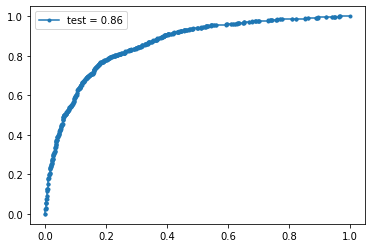

In [595]:
lr_fpr, lr_tpr, thresh = roc_curve(y_test, y)

roc_auc = auc(lr_fpr, lr_tpr)


plt.plot(lr_fpr, lr_tpr, marker='.', label=f'test = {roc_auc:.2f}')

plt.legend()

In [596]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y >= optimal_threshold))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1173
           1       0.77      0.77      0.77       947

    accuracy                           0.79      2120
   macro avg       0.79      0.79      0.79      2120
weighted avg       0.79      0.79      0.79      2120



In [455]:
forest.feature_importances_.argmin()

6

In [456]:
X_train = np.delete(X_train, forest.feature_importances_.argmin(), 1)

In [457]:
X_test = np.delete(X_test, forest.feature_importances_.argmin(), 1)

In [100]:
# feature grid for train 

feature_grid = [[True, False, False, False], [True, True, False, False], [True, False, True, False], 
                [False, False, False, True], [False, True, False, True], [False, False, True, True]] * 20


Now running with parameters: random_seed=3272, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.770117266477962

Most important features:
	Allele: 0.14589674851136583
	polarity: 0.10479801467071048
	rim: 0.1013279868559939
	mjenergy: 0.09549393505862946


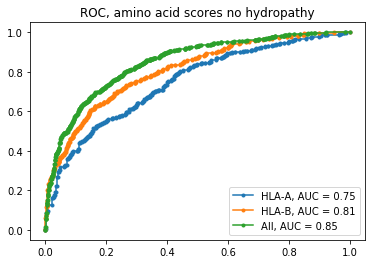




Now running with parameters: random_seed=1218, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7687019813991104

Most important features:
	Allele: 0.14233006484138164
	hydropathy: 0.10494259263065424
	rim: 0.08813165487060212
	mjenergy: 0.08337522543585392


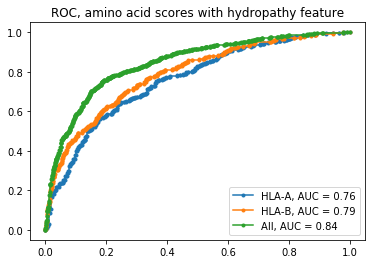




Now running with parameters: random_seed=1913, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.770117266477962

Most important features:
	Allele: 0.1146422362768212
	Cornette: 0.08910332517992085
	Engelman GES: 0.06993727591363907
	Hopp-Woods: 0.06394288197972435


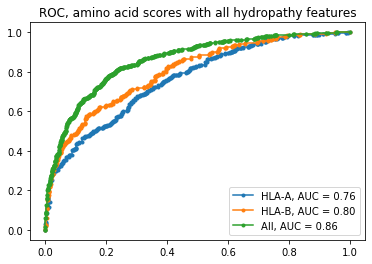




Now running with parameters: random_seed=5178, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.774767488879903

Most important features:
	kf4: 0.2601042924479451
	Allele: 0.15534922296232045
	kf7: 0.07599167378295967
	kf6: 0.06916470174602227


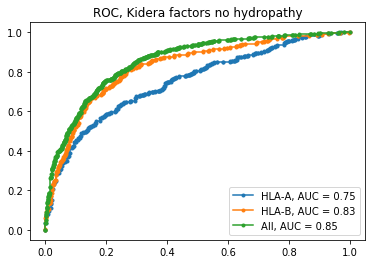




Now running with parameters: random_seed=5199, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.772745653052972

Most important features:
	kf4: 0.20642258784339249
	Allele: 0.12985648164912336
	hydropathy: 0.11562624524544406
	kf7: 0.07011847608782741


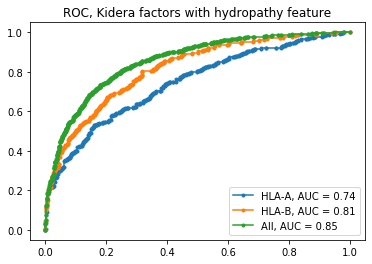




Now running with parameters: random_seed=5938, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7765871411241407

Most important features:
	kf4: 0.12327126025883833
	Allele: 0.11628238597094266
	Cornette: 0.07712708077435666
	Engelman GES: 0.06296679379042679


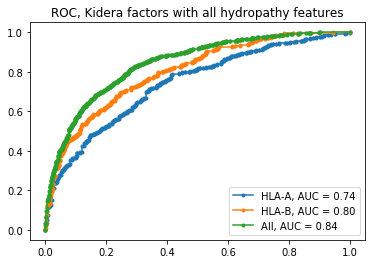




Now running with parameters: random_seed=7519, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.770319450060655

Most important features:
	Allele: 0.14511809706948212
	polarity: 0.10318291317665965
	rim: 0.10278051163590528
	mjenergy: 0.095684387585791


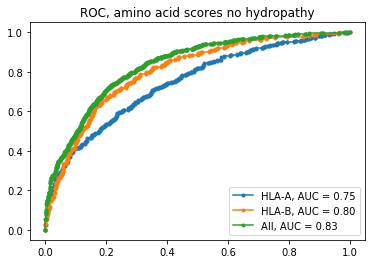




Now running with parameters: random_seed=9835, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7713303679741205

Most important features:
	Allele: 0.13011919506014152
	hydropathy: 0.10038593301576547
	rim: 0.09872924319708291
	polarity: 0.08182325115372414


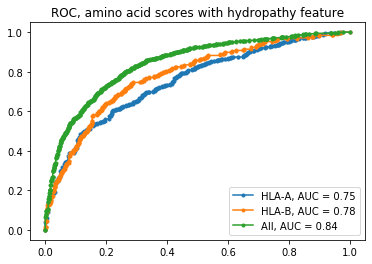




Now running with parameters: random_seed=4572, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7769915082895269

Most important features:
	Allele: 0.1065000476237744
	Cornette: 0.08119296776504277
	Engelman GES: 0.0792891545554339
	Hopp-Woods: 0.0733206503107006


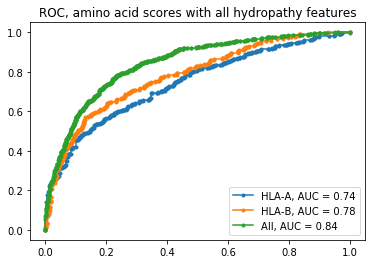




Now running with parameters: random_seed=8874, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7717347351395066

Most important features:
	kf4: 0.26144315767150783
	Allele: 0.15755392772081314
	kf7: 0.07096225382921308
	kf6: 0.06594702830751277


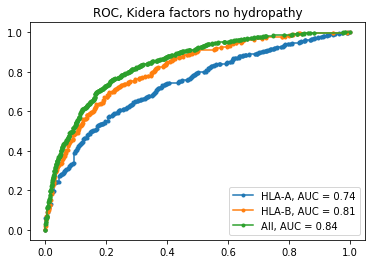




Now running with parameters: random_seed=8910, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7707238172260412

Most important features:
	kf4: 0.20801208642002378
	Allele: 0.1252435013953157
	hydropathy: 0.11636407125627704
	kf7: 0.07099772890590612


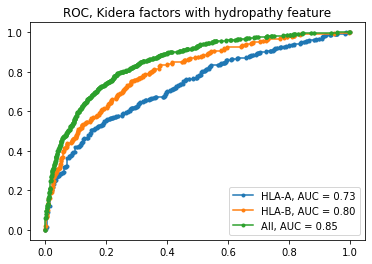




Now running with parameters: random_seed=2814, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7780024262029923

Most important features:
	kf4: 0.12941561085124093
	Allele: 0.11152456123189024
	Cornette: 0.07121695532121641
	Engelman GES: 0.06175227591168982


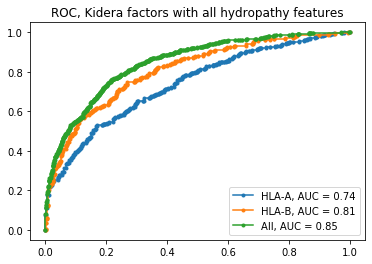




Now running with parameters: random_seed=9129, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7737565709664376

Most important features:
	Allele: 0.1298698090701733
	polarity: 0.11194373107826625
	rim: 0.10341049435373804
	mjenergy: 0.1003712804809809


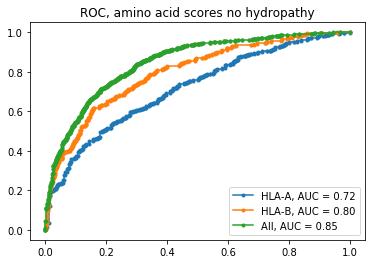




Now running with parameters: random_seed=3492, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7610190052567731

Most important features:
	Allele: 0.13011060177232442
	rim: 0.10474916708661101
	hydropathy: 0.09999630948090726
	mjenergy: 0.0800025589070645


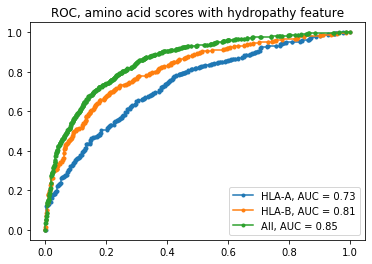




Now running with parameters: random_seed=7339, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7757784067933684

Most important features:
	Allele: 0.11394660757398893
	Engelman GES: 0.08003258222982304
	Cornette: 0.07248339978356608
	Janin: 0.06798301266460932


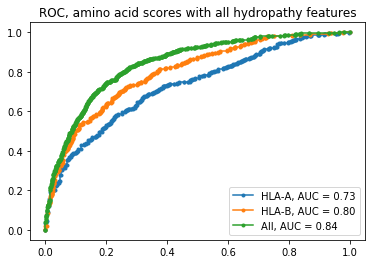




Now running with parameters: random_seed=9010, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7713303679741205

Most important features:
	kf4: 0.2573530376671019
	Allele: 0.153241426499997
	kf7: 0.07336212393191496
	kf6: 0.07005982094725602


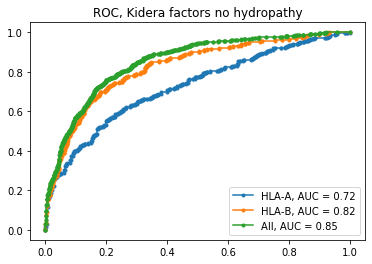




Now running with parameters: random_seed=4544, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7737565709664376

Most important features:
	kf4: 0.21298607302242958
	Allele: 0.12651633547180022
	hydropathy: 0.11796944100987469
	kf7: 0.06974219427458378


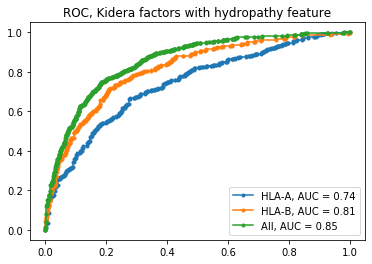




Now running with parameters: random_seed=6528, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7731500202183583

Most important features:
	kf4: 0.1276001834634356
	Allele: 0.11223505271001331
	Engelman GES: 0.0648649594466006
	Cornette: 0.061020692155652555


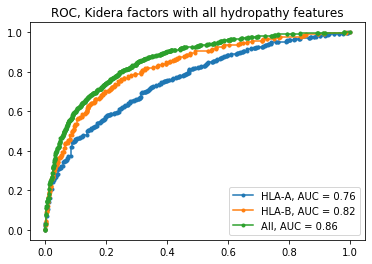




Now running with parameters: random_seed=2643, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.763243024666397

Most important features:
	Allele: 0.14891905356028626
	polarity: 0.11021511065881931
	rim: 0.10140415706927236
	mjenergy: 0.0937025323408145


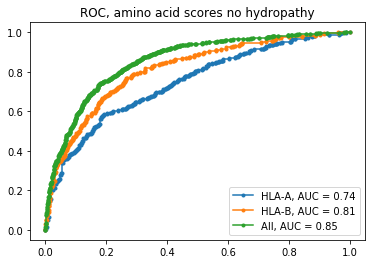




Now running with parameters: random_seed=643, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.767691063485645

Most important features:
	Allele: 0.1436408171301471
	hydropathy: 0.09720352218426605
	rim: 0.09703494158298567
	polarity: 0.08873338051995064


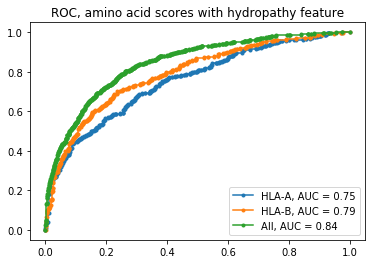




Now running with parameters: random_seed=4698, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7717347351395066

Most important features:
	Allele: 0.11037130502618614
	Cornette: 0.08164524931813778
	Engelman GES: 0.07228493782374545
	Hopp-Woods: 0.0675641649795533


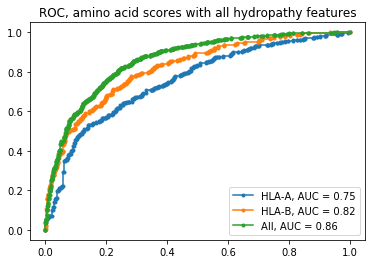




Now running with parameters: random_seed=3236, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7674888799029519

Most important features:
	kf4: 0.2549153627737877
	Allele: 0.15164136059262648
	kf7: 0.07189795180173716
	kf6: 0.06596472015143012


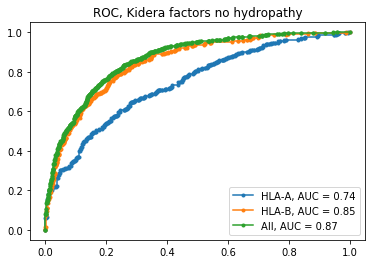




Now running with parameters: random_seed=2190, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7687019813991104

Most important features:
	kf4: 0.20696844472735595
	Allele: 0.14228483131609485
	hydropathy: 0.11531846978003117
	kf7: 0.06507743408599198


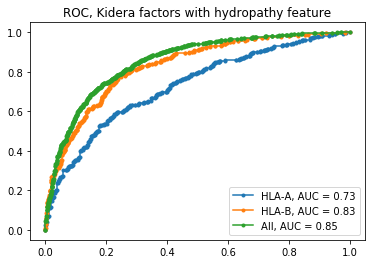




Now running with parameters: random_seed=8407, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.774767488879903

Most important features:
	kf4: 0.1311645258867238
	Allele: 0.10159891642416018
	Engelman GES: 0.06359126567573078
	Cornette: 0.06234269272208813


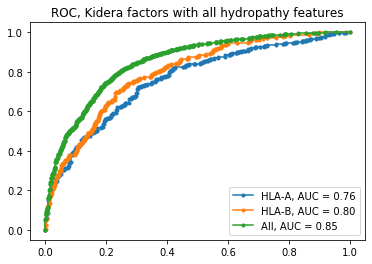




Now running with parameters: random_seed=2069, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.772543469470279

Most important features:
	Allele: 0.1386764654994603
	polarity: 0.10617066768729978
	rim: 0.10463020909992726
	mjenergy: 0.09647446447943579


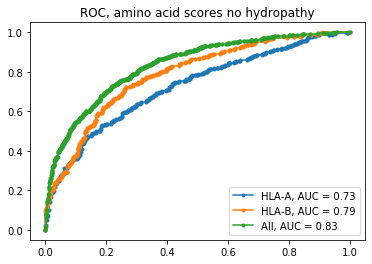




Now running with parameters: random_seed=1692, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7684997978164173

Most important features:
	Allele: 0.13681647132557878
	hydropathy: 0.10240350015875511
	rim: 0.09325102040233957
	mjenergy: 0.08122536007919211


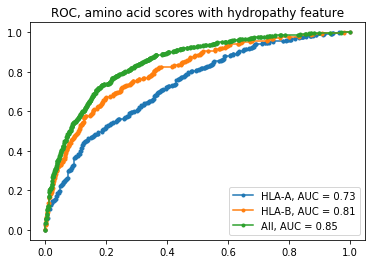




Now running with parameters: random_seed=4366, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7697128993125758

Most important features:
	Allele: 0.11631964640334802
	Cornette: 0.08023457601206237
	Engelman GES: 0.07536003381694831
	Hopp-Woods: 0.06902140084730628


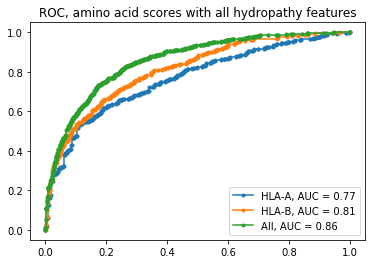




Now running with parameters: random_seed=7947, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7717347351395066

Most important features:
	kf4: 0.2543196588188526
	Allele: 0.14781139726981582
	kf7: 0.07949791147081148
	kf6: 0.06841687162268428


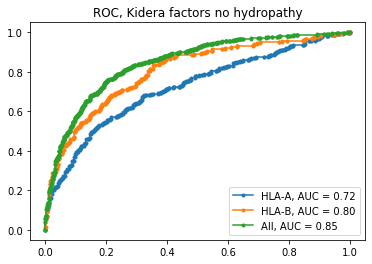




Now running with parameters: random_seed=2784, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7759805903760615

Most important features:
	kf4: 0.20813920662179225
	Allele: 0.12518451429657287
	hydropathy: 0.11514558780179596
	kf7: 0.07541267102334293


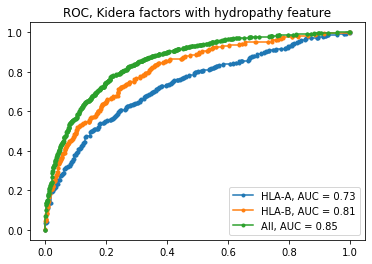




Now running with parameters: random_seed=6792, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7723412858875859

Most important features:
	kf4: 0.12396008811430517
	Allele: 0.10895746895767328
	Cornette: 0.08392971475582506
	Engelman GES: 0.06138295714434334


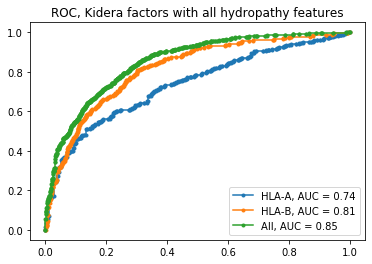




Now running with parameters: random_seed=694, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7751718560452892

Most important features:
	Allele: 0.14654500260188014
	polarity: 0.10978852213960091
	rim: 0.09902782605778467
	mjenergy: 0.09578992919069777


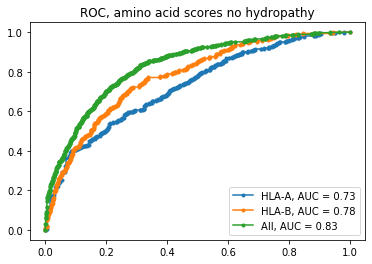




Now running with parameters: random_seed=4164, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7697128993125758

Most important features:
	Allele: 0.12525081301655935
	hydropathy: 0.10713585135106797
	rim: 0.09592481776052887
	polarity: 0.08478463795628167


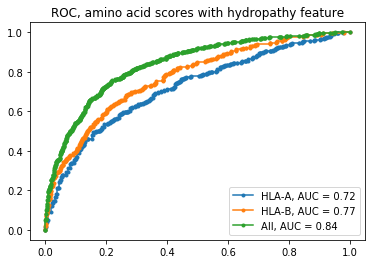




Now running with parameters: random_seed=6301, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7745653052972099

Most important features:
	Allele: 0.11043133369446756
	Engelman GES: 0.07879037341112255
	Cornette: 0.07531022850596368
	Hopp-Woods: 0.07101567162423017


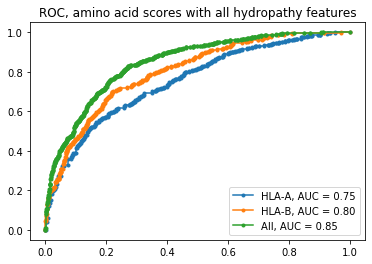




Now running with parameters: random_seed=9339, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7721391023048928

Most important features:
	kf4: 0.2535028154703507
	Allele: 0.15583655200353488
	kf7: 0.0770921359843331
	kf6: 0.06365369815841754


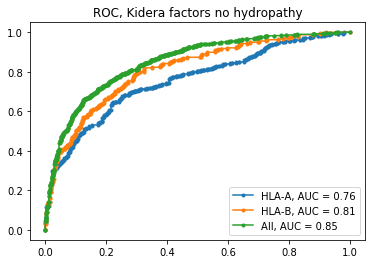




Now running with parameters: random_seed=8905, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7753740396279822

Most important features:
	kf4: 0.2151358745167428
	Allele: 0.13445351313604978
	hydropathy: 0.11569072635023242
	kf6: 0.0663672396545792


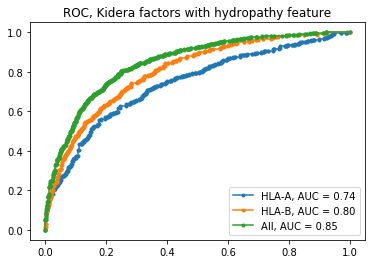




Now running with parameters: random_seed=7623, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7735543873837445

Most important features:
	kf4: 0.12752778096702827
	Allele: 0.10386251374431846
	Engelman GES: 0.07014957656043515
	Cornette: 0.06717739005157211


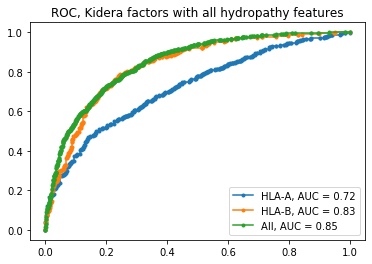




Now running with parameters: random_seed=5920, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7713303679741205

Most important features:
	Allele: 0.13676141625183538
	polarity: 0.10473267198492035
	rim: 0.10167133078288951
	mjenergy: 0.09657331193557489


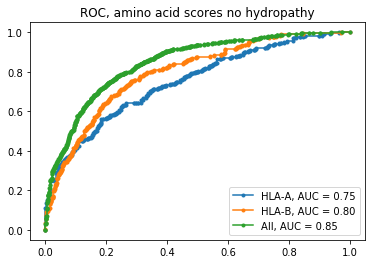




Now running with parameters: random_seed=797, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7680954306510311

Most important features:
	Allele: 0.12666790496224622
	hydropathy: 0.10712144542377847
	rim: 0.09446987472136989
	polarity: 0.08324681140593512


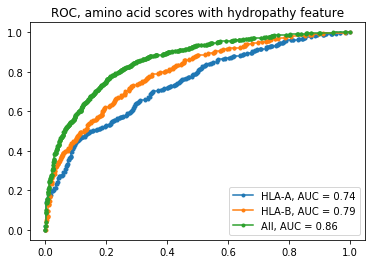




Now running with parameters: random_seed=8981, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7812373635260816

Most important features:
	Allele: 0.11448208013675713
	Engelman GES: 0.08373889392864008
	Cornette: 0.06788525653333871
	Hopp-Woods: 0.06698099636538034


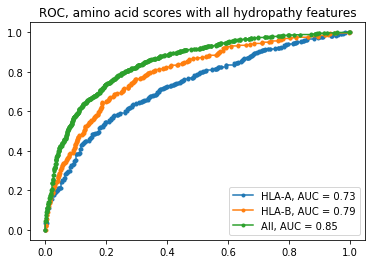




Now running with parameters: random_seed=9635, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7709260008087343

Most important features:
	kf4: 0.2577037982275157
	Allele: 0.1473239013423218
	kf7: 0.07750784765217603
	kf6: 0.06695292164960222


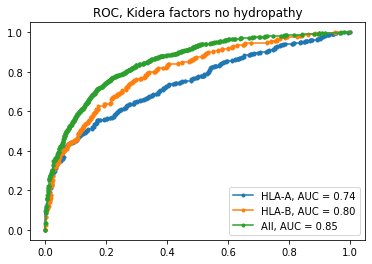




Now running with parameters: random_seed=6033, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7773958754549131

Most important features:
	kf4: 0.19495233378427088
	Allele: 0.14422554145595332
	hydropathy: 0.1141490681893439
	kf7: 0.07210630697733497


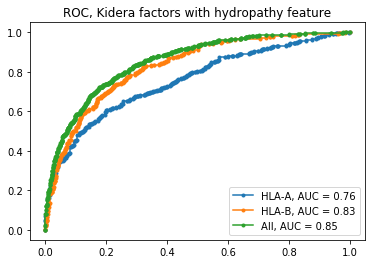




Now running with parameters: random_seed=9995, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7749696724625961

Most important features:
	kf4: 0.1259156850319203
	Allele: 0.10532546173182891
	Engelman GES: 0.07077685852529822
	Hopp-Woods: 0.06402048597551104


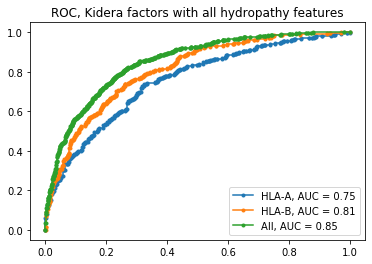




Now running with parameters: random_seed=7387, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7693085321471896

Most important features:
	Allele: 0.13935029907069643
	polarity: 0.1062396782508809
	rim: 0.10406506963285707
	mjenergy: 0.0961373457314906


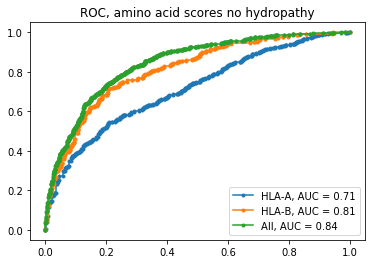




Now running with parameters: random_seed=24, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7697128993125758

Most important features:
	Allele: 0.13355838210046647
	hydropathy: 0.11024037564222497
	polarity: 0.08888534431335542
	rim: 0.08877969488227731


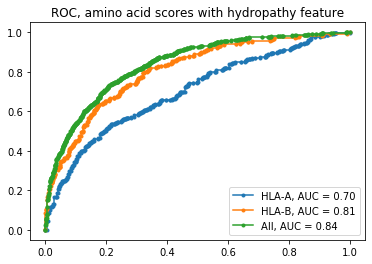




Now running with parameters: random_seed=3618, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7721391023048928

Most important features:
	Allele: 0.10189845012254801
	Engelman GES: 0.08332378956693333
	Hopp-Woods: 0.08206278085515763
	Cornette: 0.07054151261452557


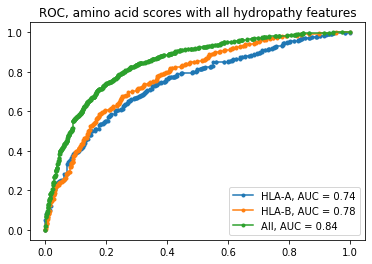




Now running with parameters: random_seed=3234, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7761827739587546

Most important features:
	kf4: 0.2614323621405417
	Allele: 0.15080942493135138
	kf7: 0.07814523068033885
	kf6: 0.06953916307930123


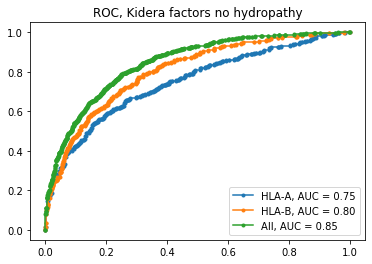




Now running with parameters: random_seed=6790, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7721391023048928

Most important features:
	kf4: 0.20696222584591906
	hydropathy: 0.1230901826853558
	Allele: 0.12243459841571346
	kf7: 0.07147871444619848


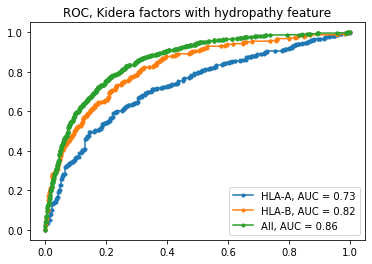




Now running with parameters: random_seed=6831, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7658714112414072

Most important features:
	kf4: 0.12719451376545435
	Allele: 0.11267544830171594
	Cornette: 0.07443902569901707
	Engelman GES: 0.06374840211375216


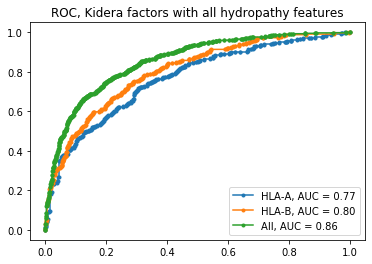




Now running with parameters: random_seed=8381, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7697128993125758

Most important features:
	Allele: 0.14107461965794724
	polarity: 0.11139232196173508
	rim: 0.10085691077043955
	mjenergy: 0.09836115532821314


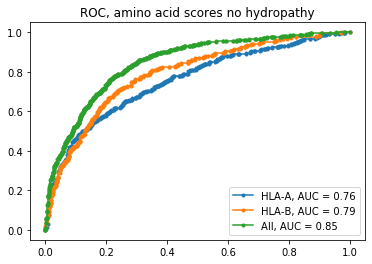




Now running with parameters: random_seed=5206, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.779619894864537

Most important features:
	Allele: 0.1384660260781991
	hydropathy: 0.1023151434096033
	polarity: 0.09383342190016958
	rim: 0.09074700447118435


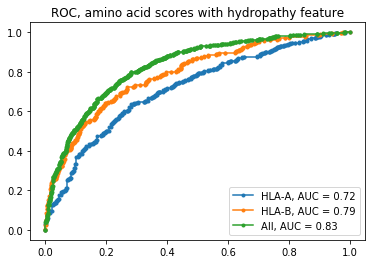




Now running with parameters: random_seed=3703, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7737565709664376

Most important features:
	Allele: 0.10467637469177865
	Engelman GES: 0.08264997297258415
	Cornette: 0.07668454823689448
	Hopp-Woods: 0.07110926539458032


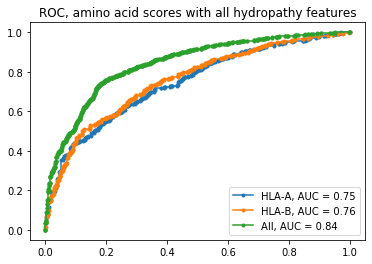




Now running with parameters: random_seed=480, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.767691063485645

Most important features:
	kf4: 0.2515676547130294
	Allele: 0.15599054093109405
	kf7: 0.07365900259851399
	kf6: 0.06838914234231695


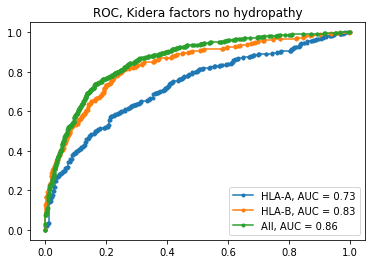




Now running with parameters: random_seed=2599, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7749696724625961

Most important features:
	kf4: 0.2098520120309464
	Allele: 0.1257526310052842
	hydropathy: 0.11562176696983276
	kf7: 0.06853412980221937


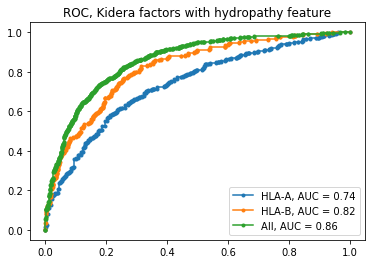




Now running with parameters: random_seed=9946, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7723412858875859

Most important features:
	kf4: 0.12183943680257307
	Allele: 0.1176389898604673
	Cornette: 0.07052580177821528
	Engelman GES: 0.057351236507733154


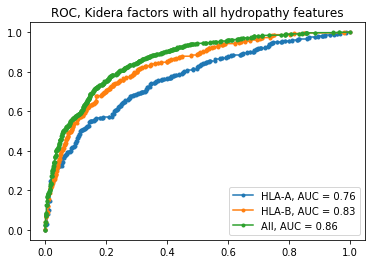




Now running with parameters: random_seed=7742, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7699150828952689

Most important features:
	Allele: 0.13918515282696603
	polarity: 0.10624300916760981
	rim: 0.0993943928399481
	mjenergy: 0.0987523503298306


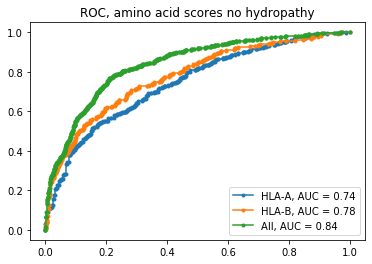




Now running with parameters: random_seed=8535, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7755762232106753

Most important features:
	Allele: 0.12785919858370845
	hydropathy: 0.11009266160095904
	rim: 0.09011969404853687
	polarity: 0.08731087945163123


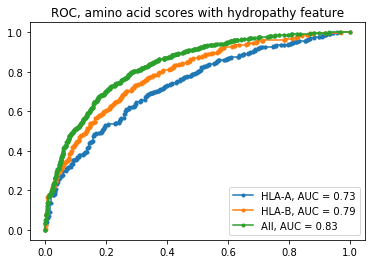




Now running with parameters: random_seed=9, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7664779619894865

Most important features:
	Allele: 0.1003257816524219
	Cornette: 0.0783120467350838
	Engelman GES: 0.07719650274645735
	Janin: 0.07181776651901334


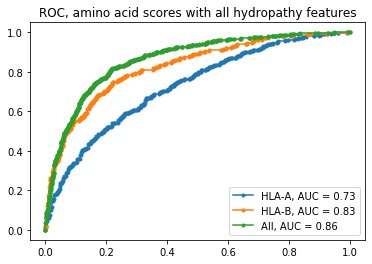




Now running with parameters: random_seed=5585, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7741609381318237

Most important features:
	kf4: 0.2559333224166397
	Allele: 0.16611052282447533
	kf7: 0.08029610647952393
	kf6: 0.06444895722852526


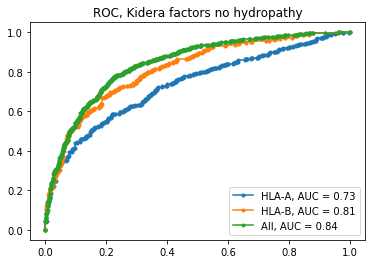




Now running with parameters: random_seed=9806, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7788111605337646

Most important features:
	kf4: 0.21448387251174336
	Allele: 0.12281529588187311
	hydropathy: 0.12126211976603608
	kf7: 0.07398430427161092


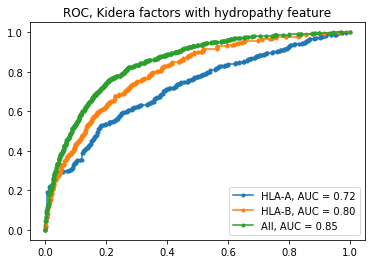




Now running with parameters: random_seed=3589, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7646583097452487

Most important features:
	kf4: 0.1224699152983516
	Allele: 0.11539479197320936
	Cornette: 0.07165025683299292
	Engelman GES: 0.06060584898847877


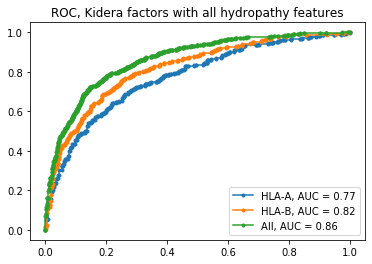




Now running with parameters: random_seed=3589, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7624342903356247

Most important features:
	Allele: 0.1444199250038927
	rim: 0.1065995480190888
	mjenergy: 0.09736266730310997
	polarity: 0.09236100213982856


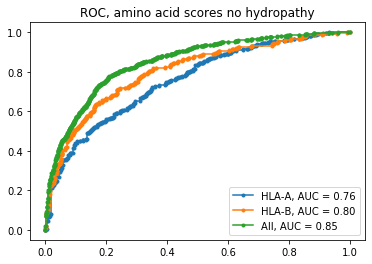




Now running with parameters: random_seed=2150, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7684997978164173

Most important features:
	Allele: 0.12516056689959565
	hydropathy: 0.10835598769983827
	rim: 0.1005600444228401
	polarity: 0.08240419676484431


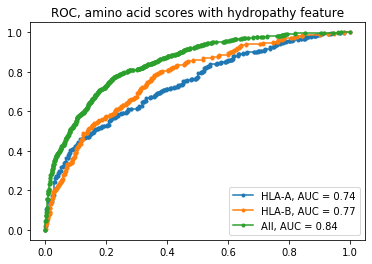




Now running with parameters: random_seed=920, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7691063485644966

Most important features:
	Allele: 0.11066941420157131
	Cornette: 0.07930402696435311
	Engelman GES: 0.07904566020187957
	Hopp-Woods: 0.07087603701291864


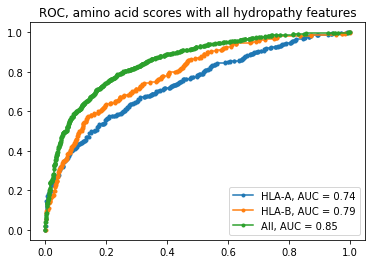




Now running with parameters: random_seed=9708, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7731500202183583

Most important features:
	kf4: 0.25756623152266045
	Allele: 0.16263154525472398
	kf7: 0.07377696537003216
	kf6: 0.06701008456786302


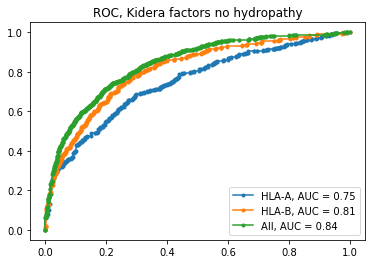




Now running with parameters: random_seed=5987, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7695107157298827

Most important features:
	kf4: 0.20047831149247147
	Allele: 0.13583394781999578
	hydropathy: 0.11516025981830849
	kf7: 0.07067649322325151


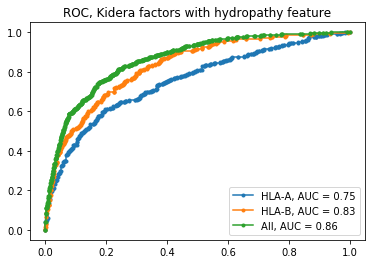




Now running with parameters: random_seed=1382, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.77719369187222

Most important features:
	kf4: 0.1318004593111097
	Allele: 0.1003788111390311
	Engelman GES: 0.07069062232430841
	Cornette: 0.0655339539594808


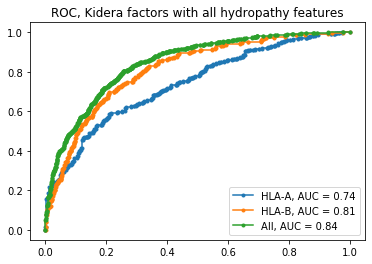




Now running with parameters: random_seed=2728, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7668823291548726

Most important features:
	Allele: 0.1349375099572779
	polarity: 0.1095879751791892
	rim: 0.10454696169211532
	mjenergy: 0.09753752701742881


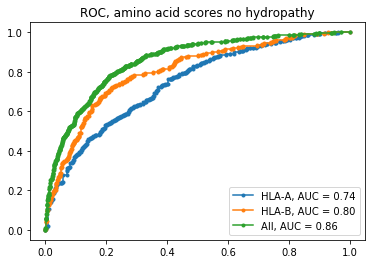




Now running with parameters: random_seed=5523, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7666801455721796

Most important features:
	Allele: 0.13014258928793526
	hydropathy: 0.10309752313563411
	polarity: 0.08862150192559991
	rim: 0.08798908403042695


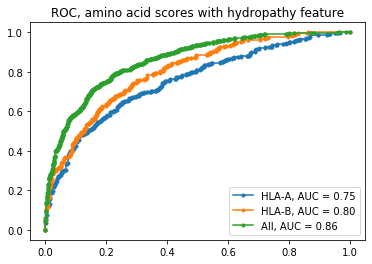




Now running with parameters: random_seed=549, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7757784067933684

Most important features:
	Allele: 0.10993213104753453
	Engelman GES: 0.0759125343216701
	Cornette: 0.07588206104779063
	Janin: 0.06956690608408056


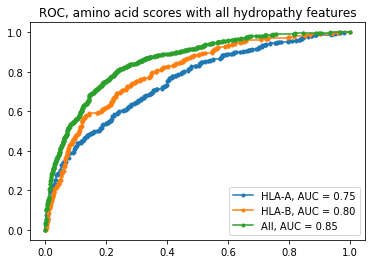




Now running with parameters: random_seed=4442, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7705216336433481

Most important features:
	kf4: 0.26340520283543795
	Allele: 0.15274429082414157
	kf7: 0.07783407216197599
	kf6: 0.06660156435210432


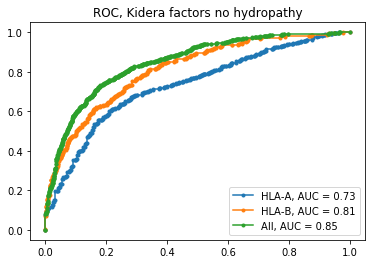




Now running with parameters: random_seed=7656, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7680954306510311

Most important features:
	kf4: 0.20017573746610126
	Allele: 0.13934371809705004
	hydropathy: 0.11409613611153152
	kf7: 0.07074868573524043


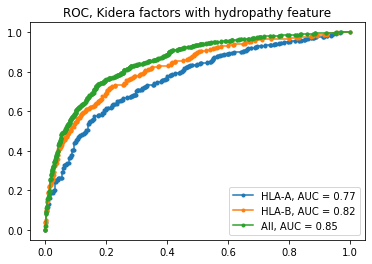




Now running with parameters: random_seed=1686, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7723412858875859

Most important features:
	kf4: 0.1283049551397628
	Allele: 0.11199420769711493
	Cornette: 0.07594253857493902
	kf7: 0.056320843913205666


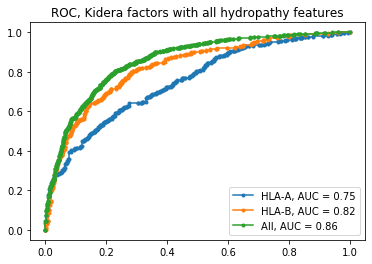




Now running with parameters: random_seed=6626, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7650626769106349

Most important features:
	Allele: 0.13034200604224963
	polarity: 0.10796520712979979
	rim: 0.1047598524356605
	mjenergy: 0.09634330771981864


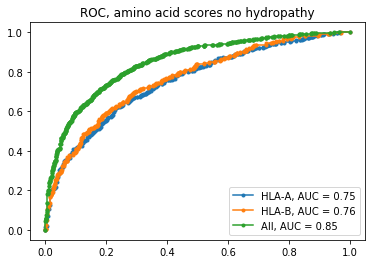




Now running with parameters: random_seed=9405, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7729478366356651

Most important features:
	Allele: 0.12355951492432757
	hydropathy: 0.10750143738057401
	polarity: 0.09360414615858298
	rim: 0.09180969456682224


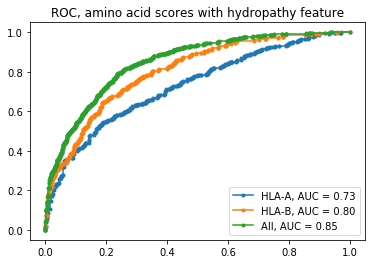




Now running with parameters: random_seed=7499, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7684997978164173

Most important features:
	Allele: 0.11107018730964081
	Cornette: 0.07728833231061136
	Janin: 0.0699083868594309
	Engelman GES: 0.06911071224934809


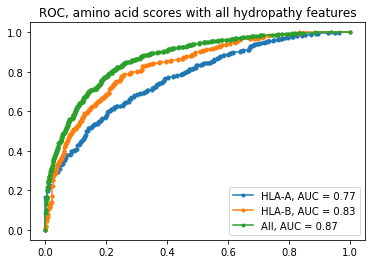




Now running with parameters: random_seed=4142, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7765871411241407

Most important features:
	kf4: 0.25256975394714054
	Allele: 0.16216523428102952
	kf7: 0.07630301525532107
	kf3: 0.06410292714211405


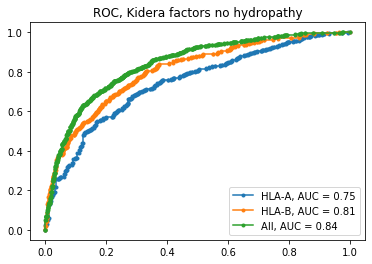




Now running with parameters: random_seed=8504, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7775980590376061

Most important features:
	kf4: 0.19802725797452503
	Allele: 0.15144797313283517
	hydropathy: 0.1125876789321891
	kf7: 0.07392882712461873


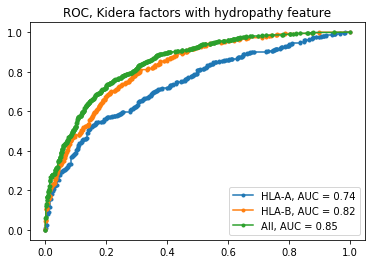




Now running with parameters: random_seed=8140, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7767893247068338

Most important features:
	kf4: 0.12712327955547711
	Allele: 0.12011848796191346
	Cornette: 0.07168720908041494
	Engelman GES: 0.05752839559602664


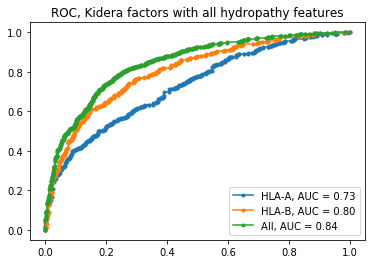




Now running with parameters: random_seed=377, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7765871411241407

Most important features:
	Allele: 0.14819080840151314
	polarity: 0.11073742774240761
	rim: 0.10590540173700617
	mjenergy: 0.09135415361933326


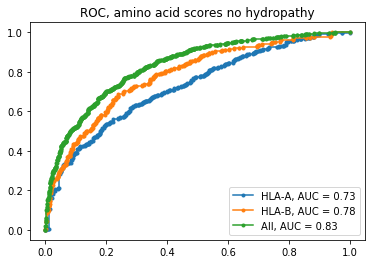




Now running with parameters: random_seed=4646, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7666801455721796

Most important features:
	Allele: 0.1295582291752569
	hydropathy: 0.10496546350953544
	rim: 0.08938701999096783
	polarity: 0.08886507468144572


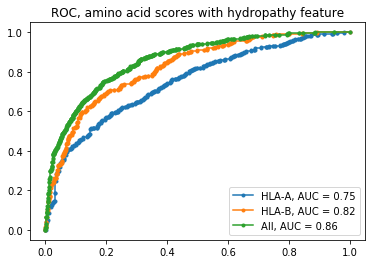




Now running with parameters: random_seed=9907, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7715325515568136

Most important features:
	Allele: 0.11220505290654628
	Engelman GES: 0.08042028896634086
	Cornette: 0.07458514222992997
	Hopp-Woods: 0.06663073461667296


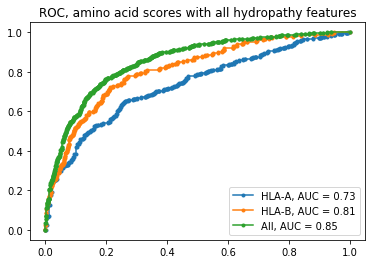




Now running with parameters: random_seed=2068, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7711281843914274

Most important features:
	kf4: 0.2544837982892124
	Allele: 0.1538058621343305
	kf7: 0.07713147742259821
	kf6: 0.06836478222872355


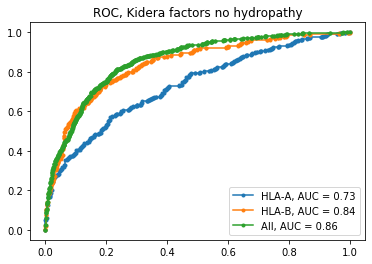




Now running with parameters: random_seed=2733, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7757784067933684

Most important features:
	kf4: 0.204981685458944
	Allele: 0.137359473817774
	hydropathy: 0.11428282979926319
	kf7: 0.07106590972365856


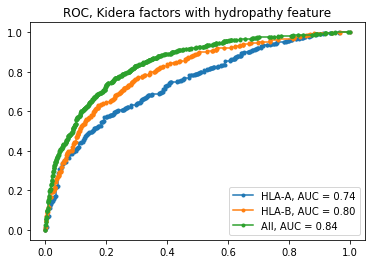




Now running with parameters: random_seed=5974, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7810351799433886

Most important features:
	kf4: 0.12064285088656436
	Allele: 0.11823872659637868
	Cornette: 0.0792524226622352
	Engelman GES: 0.06210476268591225


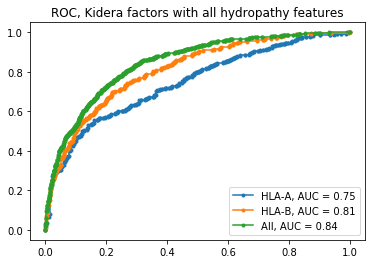




Now running with parameters: random_seed=4588, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7691063485644966

Most important features:
	Allele: 0.14287067953502175
	polarity: 0.11109523254897782
	rim: 0.10173656719517928
	mjenergy: 0.09891218596583307


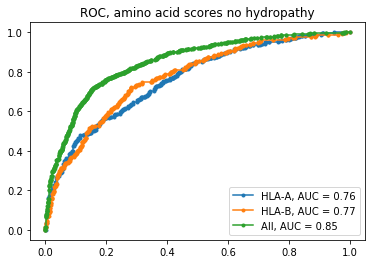




Now running with parameters: random_seed=3210, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7646583097452487

Most important features:
	Allele: 0.12873830740497874
	hydropathy: 0.10373301386684494
	rim: 0.09679319541429562
	mjenergy: 0.0824131488264457


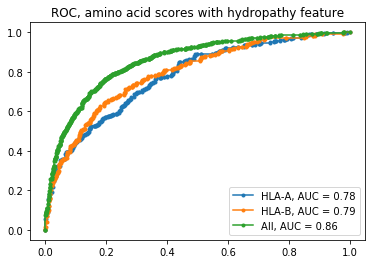




Now running with parameters: random_seed=952, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7757784067933684

Most important features:
	Allele: 0.1158815829545249
	Cornette: 0.08137755680901683
	Engelman GES: 0.07368490362156174
	Janin: 0.06846729033333335


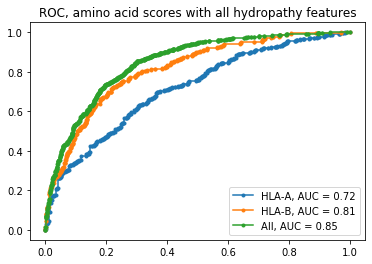




Now running with parameters: random_seed=8949, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7691063485644966

Most important features:
	kf4: 0.24596620134190592
	Allele: 0.16651555347729022
	kf7: 0.0766055002380844
	kf6: 0.07098936511026656


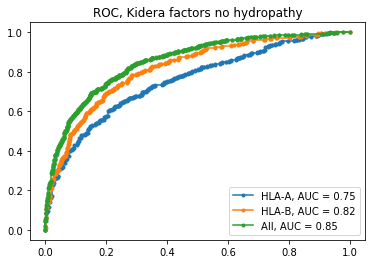




Now running with parameters: random_seed=354, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7682976142337242

Most important features:
	kf4: 0.20244515701778026
	Allele: 0.13774853120264013
	hydropathy: 0.12148788248251807
	kf7: 0.06651188372092606


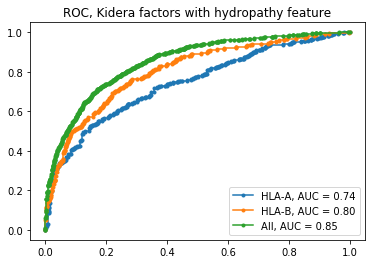




Now running with parameters: random_seed=7320, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7759805903760615

Most important features:
	kf4: 0.12620102767388738
	Allele: 0.113102471260723
	Cornette: 0.07074580984282966
	Engelman GES: 0.05994351772247813


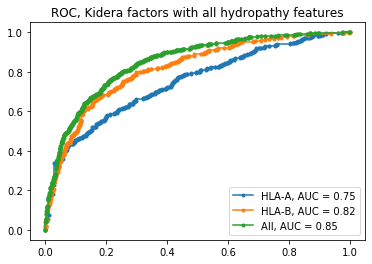




Now running with parameters: random_seed=6237, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7695107157298827

Most important features:
	Allele: 0.13400184196633658
	rim: 0.1071708508203243
	polarity: 0.10003210400574611
	mjenergy: 0.09969801058389585


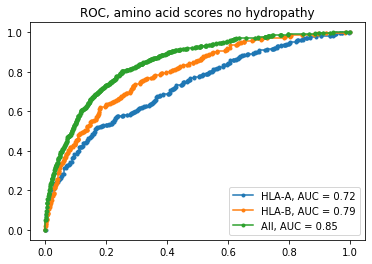




Now running with parameters: random_seed=5151, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7773958754549131

Most important features:
	Allele: 0.13646739762056231
	hydropathy: 0.10341324414546058
	rim: 0.09128710192848977
	polarity: 0.08617190659323992


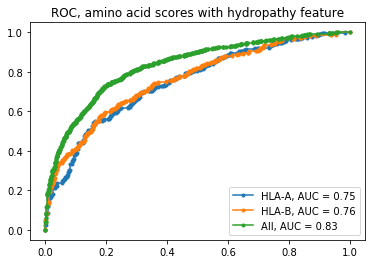




Now running with parameters: random_seed=3301, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7735543873837445

Most important features:
	Allele: 0.11896908629113921
	Engelman GES: 0.07668419105194292
	Cornette: 0.07259045371438089
	Hopp-Woods: 0.07233138585241217


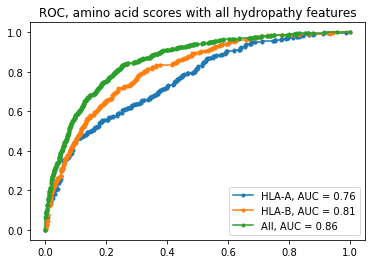




Now running with parameters: random_seed=6349, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7729478366356651

Most important features:
	kf4: 0.249820469727864
	Allele: 0.1576757091772613
	kf7: 0.07660604165551167
	kf6: 0.0676948965787188


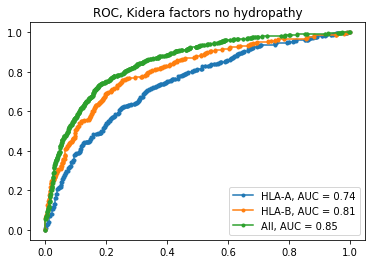




Now running with parameters: random_seed=7771, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7759805903760615

Most important features:
	kf4: 0.2013696893465125
	Allele: 0.12569510770042147
	hydropathy: 0.11528820463160908
	kf7: 0.07104137993055998


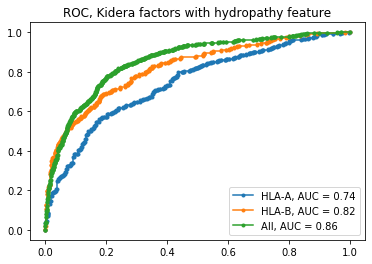




Now running with parameters: random_seed=6636, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7687019813991104

Most important features:
	kf4: 0.12559235526843102
	Allele: 0.10324614607098623
	Cornette: 0.06436141863084652
	Hopp-Woods: 0.06096537966646626


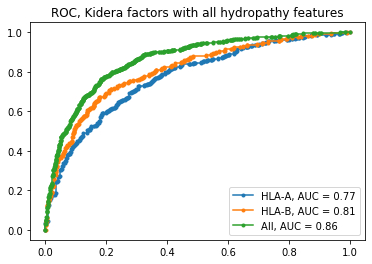




Now running with parameters: random_seed=6076, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7695107157298827

Most important features:
	Allele: 0.1435496821571957
	polarity: 0.1053823303264309
	rim: 0.10156942945884988
	mjenergy: 0.09007134246965687


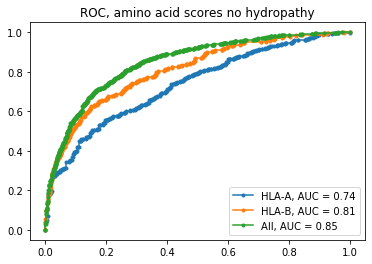




Now running with parameters: random_seed=5007, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.770319450060655

Most important features:
	Allele: 0.14492370753748524
	hydropathy: 0.10647366938672141
	rim: 0.09527781290022241
	mjenergy: 0.0802745122985469


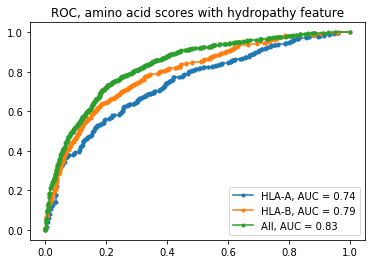




Now running with parameters: random_seed=2682, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7705216336433481

Most important features:
	Allele: 0.10863189726626567
	Cornette: 0.08343094394484935
	Janin: 0.06759783967532779
	Engelman GES: 0.06686861276680137


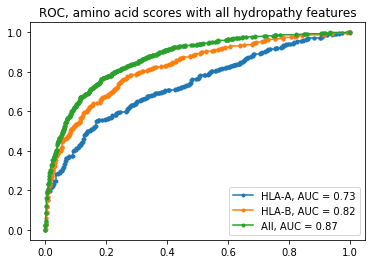




Now running with parameters: random_seed=9279, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.770117266477962

Most important features:
	kf4: 0.2604508230715133
	Allele: 0.14869647175373302
	kf7: 0.07624495381065094
	kf6: 0.07005024186812361


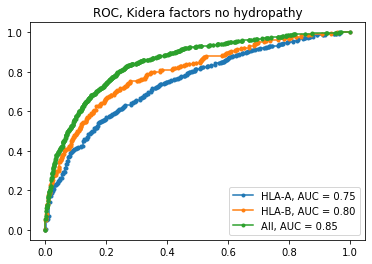




Now running with parameters: random_seed=934, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.772745653052972

Most important features:
	kf4: 0.20315519598987897
	Allele: 0.15291363494835705
	hydropathy: 0.11450246522617254
	kf7: 0.06885284147788552


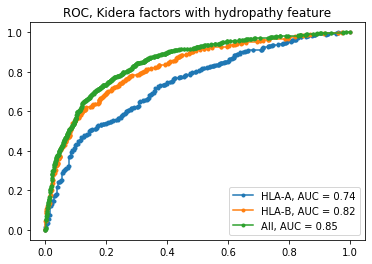




Now running with parameters: random_seed=526, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7717347351395066

Most important features:
	Allele: 0.11925621288818332
	kf4: 0.11809426640189867
	Cornette: 0.07234676182324697
	Janin: 0.055389297445332344


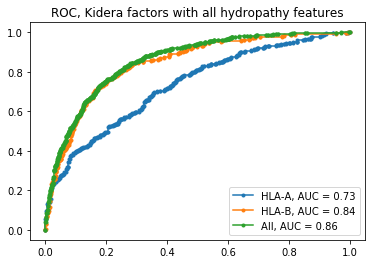




Now running with parameters: random_seed=3953, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7644561261625556

Most important features:
	Allele: 0.13685942349251634
	rim: 0.10768303530739755
	polarity: 0.10542881939697817
	mjenergy: 0.09527658254710386


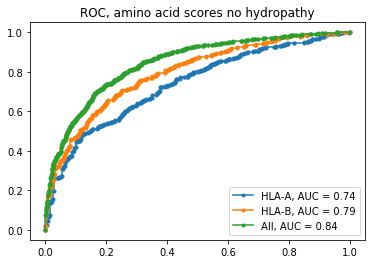




Now running with parameters: random_seed=8674, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7636473918317832

Most important features:
	Allele: 0.13489251443128936
	hydropathy: 0.10500372052529577
	rim: 0.0914450613577806
	mjenergy: 0.0821523512654165


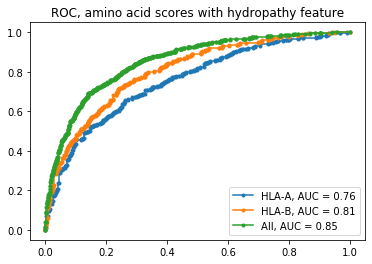




Now running with parameters: random_seed=3257, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7733522038010514

Most important features:
	Allele: 0.12205795165347193
	Cornette: 0.08166246045201563
	Engelman GES: 0.0751783700452265
	Hopp-Woods: 0.06666832827868426


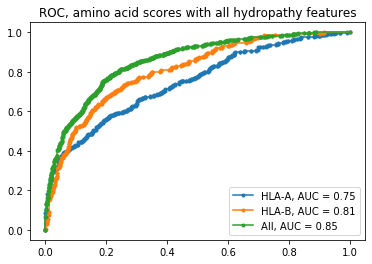




Now running with parameters: random_seed=3509, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7723412858875859

Most important features:
	kf4: 0.255140694841515
	Allele: 0.1539020005757139
	kf7: 0.07382941651878487
	kf6: 0.06801717477851295


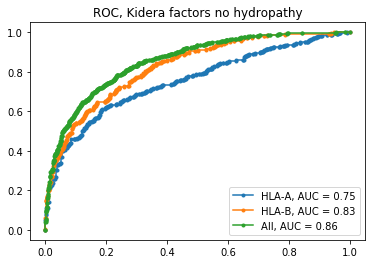




Now running with parameters: random_seed=6261, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7757784067933684

Most important features:
	kf4: 0.1963129150708123
	Allele: 0.14934565087873325
	hydropathy: 0.1152834699858405
	kf7: 0.06950664152624314


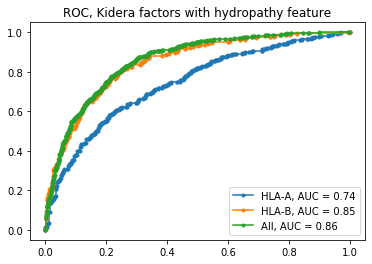




Now running with parameters: random_seed=174, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7717347351395066

Most important features:
	kf4: 0.12255977907469168
	Allele: 0.09841645120685959
	Cornette: 0.0747864463152192
	Engelman GES: 0.06632433997787684


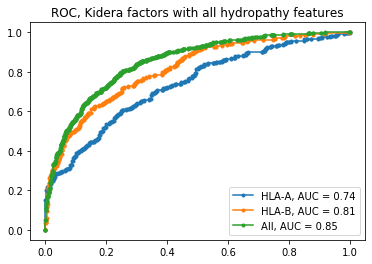




Now running with parameters: random_seed=29, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7693085321471896

Most important features:
	Allele: 0.14356393158454736
	rim: 0.10488841960495779
	polarity: 0.10312113685282416
	mjenergy: 0.09920401833368454


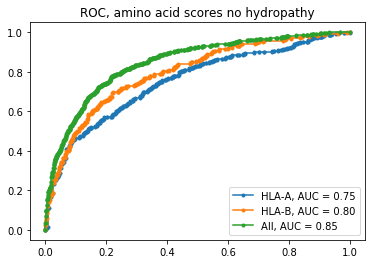




Now running with parameters: random_seed=9714, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7709260008087343

Most important features:
	Allele: 0.13526935725129136
	hydropathy: 0.10224438248962145
	rim: 0.09769326666681377
	polarity: 0.09090421907403642


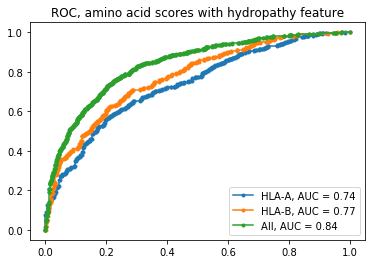




Now running with parameters: random_seed=3247, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7753740396279822

Most important features:
	Allele: 0.1052923311391541
	Cornette: 0.0823839015816207
	Engelman GES: 0.07872970674938877
	Hopp-Woods: 0.06970371116901226


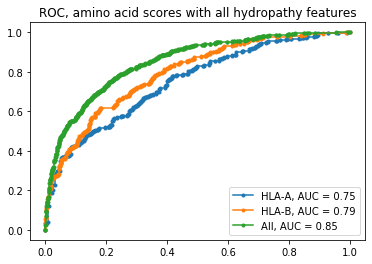




Now running with parameters: random_seed=4247, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7753740396279822

Most important features:
	kf4: 0.264291693185489
	Allele: 0.15473933701805495
	kf7: 0.07267530247094266
	kf6: 0.06804569195006543


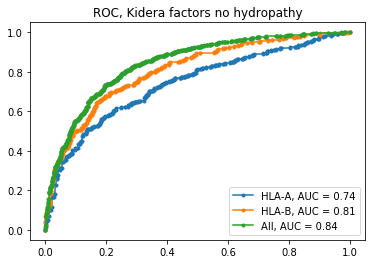




Now running with parameters: random_seed=8344, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7737565709664376

Most important features:
	kf4: 0.21318022914131035
	Allele: 0.1311333176820488
	hydropathy: 0.11698904821962883
	kf7: 0.07345202181549182


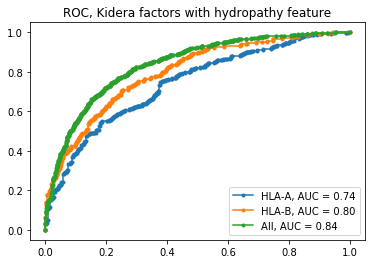




Now running with parameters: random_seed=8904, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7737565709664376

Most important features:
	kf4: 0.12562204376251299
	Allele: 0.1097124756067006
	Cornette: 0.07287166760356027
	Engelman GES: 0.06270924020651307


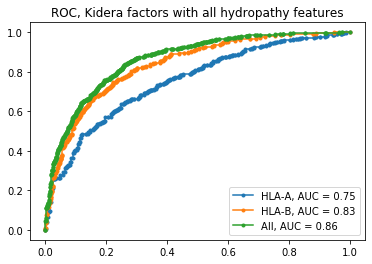




Now running with parameters: random_seed=5561, aa=True, hydropathy=False, hydropathy_all=False, kidera=False
OOB score = 0.7733522038010514

Most important features:
	Allele: 0.14364352810501813
	polarity: 0.11171091907805403
	rim: 0.10486141207923826
	mjenergy: 0.09738536447977318


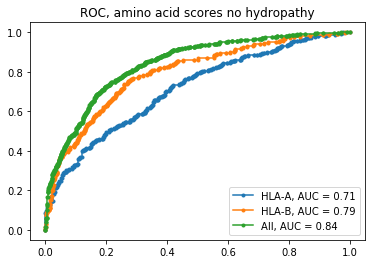




Now running with parameters: random_seed=6071, aa=True, hydropathy=True, hydropathy_all=False, kidera=False
OOB score = 0.7668823291548726

Most important features:
	Allele: 0.13499210883804158
	hydropathy: 0.10054226973414122
	rim: 0.09401658117667595
	polarity: 0.0863401980487235


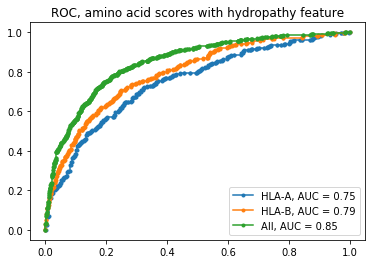




Now running with parameters: random_seed=4670, aa=True, hydropathy=False, hydropathy_all=True, kidera=False
OOB score = 0.7721391023048928

Most important features:
	Allele: 0.10433117523298732
	Cornette: 0.0802169468814485
	Engelman GES: 0.07514758419071361
	Janin: 0.07293901328557979


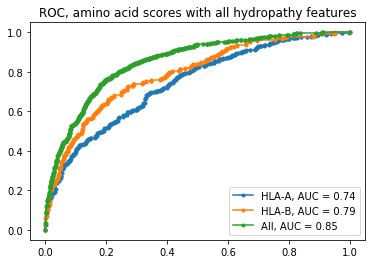




Now running with parameters: random_seed=5436, aa=False, hydropathy=False, hydropathy_all=False, kidera=True
OOB score = 0.7735543873837445

Most important features:
	kf4: 0.2483230169381259
	Allele: 0.16723380573200536
	kf7: 0.0753912703703397
	kf6: 0.07142397697591446


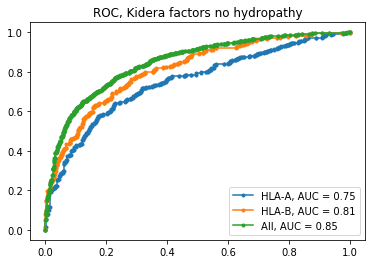




Now running with parameters: random_seed=919, aa=False, hydropathy=True, hydropathy_all=False, kidera=True
OOB score = 0.7759805903760615

Most important features:
	kf4: 0.2239916361072476
	Allele: 0.12071367047616072
	hydropathy: 0.11703810322207721
	kf7: 0.07314651164748222


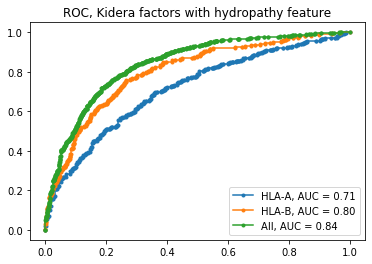




Now running with parameters: random_seed=8257, aa=False, hydropathy=False, hydropathy_all=True, kidera=True
OOB score = 0.7715325515568136

Most important features:
	kf4: 0.12746441974248895
	Allele: 0.09085291030779667
	Cornette: 0.07539412005790525
	Janin: 0.06814517899553138


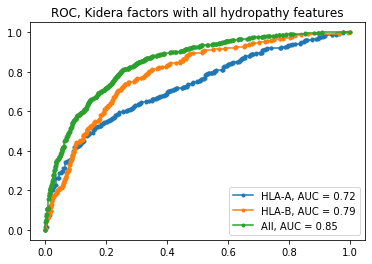

In [101]:
# results dataset where the returned data will be stored
results = pd.DataFrame(
    columns=['random_seed', 'aa', 'hydropathy', 'hydropathy_all', 'kidera', 'OOB', 'AUC_A', 'AUC_B', 'AUC'])

# applying feature grid
for features in feature_grid:
    # random state to keep track of them
    random_state = np.random.randint(0, 10000)
    
    iteration_result = train(dataset, random_state, *features)[:-5]
    results.loc[len(results)] = [random_state] + features + iteration_result

In [103]:
results

random_seed     aa hydropathy hydropathy_all kidera       OOB     AUC_A  \
0          3272   True      False          False  False  0.770117  0.747480   
1          1218   True       True          False  False  0.768702  0.757663   
2          1913   True      False           True  False  0.770117  0.761365   
3          5178  False      False          False   True  0.774767  0.751049   
4          5199  False       True          False   True  0.772746  0.743345   
..          ...    ...        ...            ...    ...       ...       ...   
115        6071   True       True          False  False  0.766882  0.747897   
116        4670   True      False           True  False  0.772139  0.741785   
117        5436  False      False          False   True  0.773554  0.748388   
118         919  False       True          False   True  0.775981  0.713371   
119        8257  False      False           True   True  0.771533  0.724468   

        AUC_B       AUC  
0    0.807405  0.848615  
1    0.787840  0.844308  
2    0.800434  0.857287  
3    0.826008  0.854432  
4    0.814871  0.854717  
..        ...       ...  
115  0.793095  0.848482  
116  0.789011  0.850521  
117  0.810720  0.847665  
118  0.800641  0.841155  
119  0.789996  0.846564  

[120 rows x 9 columns]

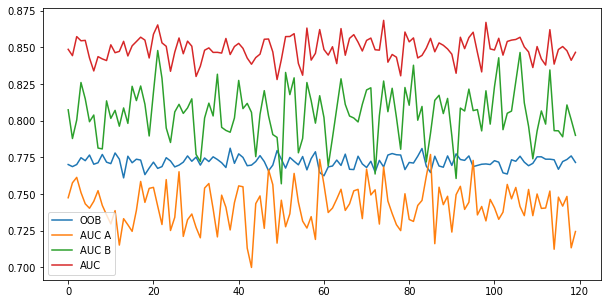

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(results.OOB, label='OOB')
plt.plot(results.AUC_A, label='AUC A')
plt.plot(results.AUC_B, label='AUC B')
plt.plot(results.AUC, label='AUC')
plt.legend()

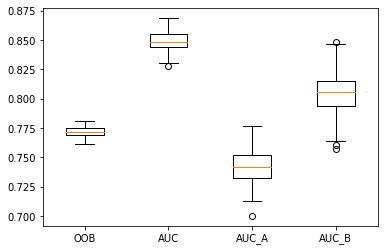

In [117]:
bp = plt.boxplot([results.OOB, results.AUC, results.AUC_A, results.AUC_B], labels=['OOB', 'AUC', 'AUC_A', 'AUC_B'])
# plt.legend()

In [118]:
forest

NameError: name 'forest' is not defined

In [120]:
df = prepare_data(dataset)

alpha  charge   core   pH  polarity    rim  surface   turn  volume  \
0     11.05    -2.0  0.554 -4.0       6.0  0.659    0.654   8.43  1055.0   
1      8.79    -1.0  0.511 -3.0       2.0  0.427    0.456   8.56   971.0   
2      9.68     1.0  0.626  0.0       4.0  0.657    0.647  11.73  1076.0   
3      9.29     1.0  0.626 -4.0       4.0  0.672    0.671  12.83  1053.0   
4      9.30     1.0  0.579  1.0       3.0  0.516    0.540   8.13   972.0   
...     ...     ...    ...  ...       ...    ...      ...    ...     ...   
9883  10.60     2.0  0.491  6.0       4.0  0.410    0.476   6.72  1026.0   
9884   9.75     1.0  0.450  1.0       6.0  0.560    0.560   8.28   940.0   
9885  11.95     3.0  0.585  6.0       8.0  0.696    0.622  10.82  1243.0   
9886  11.07    -2.0  0.504 -4.0       7.0  0.540    0.521   8.68  1165.0   
9887   9.36     2.0  0.459  4.0       5.0  0.485    0.480   7.75  1033.0   

      count  strength  disorder  mjenergy  target  Allele  
0       9.0       3.0       3.0  -27.7740       1       0  
1       9.0       6.0      -1.0  -33.7800       1       0  
2      11.0       2.0       4.0  -30.1825       1       0  
3      11.0       2.0       3.0  -29.8235       1       0  
4       9.0       4.0       0.0  -31.7840       1       0  
...     ...       ...       ...       ...     ...     ...  
9883    9.0       3.0      -2.0  -30.4510       0       1  
9884    9.0       2.0       3.0  -24.8695       0       1  
9885   11.0       3.0       5.0  -30.6655       0       1  
9886   10.0       4.0       2.0  -30.7520       0       1  
9887    9.0       3.0       1.0  -27.4570       0       1  

[7066 rows x 15 columns]

In [129]:
results.groupby(['aa', 'hydropathy', 'hydropathy_all', 'kidera']).median()

OOB     AUC_A     AUC_B       AUC
aa    hydropathy hydropathy_all kidera                                        
False False      False          True    0.771937  0.742953  0.811537  0.848985
                 True           True    0.773352  0.747084  0.811607  0.850462
      True       False          True    0.774363  0.740194  0.816307  0.852850
True  False      False          False   0.769612  0.743817  0.794656  0.846255
                 True           False   0.772746  0.744642  0.801131  0.852010
      True       False          False   0.768601  0.741260  0.792268  0.844493

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2bc8c978>,
      dtype=object)

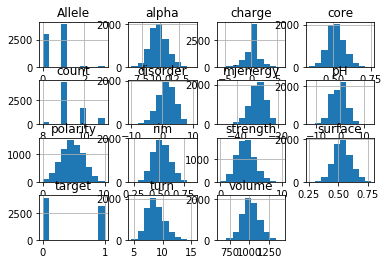

In [130]:
df.hist()

In [ ]:
# X_train, X_test, y_train, y_test, forest

In [59]:
y_train_pred = forest.predict_proba(X_train)[:, 1]
y_test_pred = forest.predict_proba(X_test)[:, 1]


NameError: name 'forest' is not defined

In [244]:
shape

(4946,)

In [254]:
y_train.iloc[arr1inds[::-1]]

2608    1
4408    1
3362    1
2859    1
1667    1
       ..
8055    0
5043    0
7912    0
8423    0
5111    0
Name: target, Length: 4946, dtype: int64

In [58]:
arr1inds = y_train_pred.argsort()
sorted_arr1 = y_train_pred[arr1inds[::-1]]
Z_sorted = y_train.iloc[arr1inds[::-1]]

NameError: name 'y_train_pred' is not defined

In [260]:
arr1inds_test = y_test_pred.argsort()

Z_sorted_test = y_test.iloc[arr1inds_test[::-1]]

In [215]:
for a, b in zip(y_train, y_train_pred):
    print(a, b)

1 0.40757096189235675
1 0.715660978902576
0 0.2264261331245784
1 0.832745762780467
1 0.9748078763510203
1 0.8592948585977502
0 0.09608383198387542
0 0.12631608793609833
0 0.2710127424631437
1 0.5464228628723822
0 0.18637374100497456
1 0.4874546854763375
0 0.2062596176756324
0 0.49184797814739206
1 0.40746383998164265
0 0.48115468847098497
1 0.6348778623611705
0 0.08205075472969889
0 0.33506699001512763
1 0.6511579881790224
1 0.9702395734278811
0 0.04994052143898207
1 0.7533489507948571
1 0.9743560408604233
0 0.3179618162337437
1 0.6897995432285638
1 0.5449176481241734
0 0.31327398001848483
1 0.7047112940952522
0 0.0926373971691513
1 0.6503642056276572
1 0.8726151980000301
0 0.20806795953001794
1 0.5474197150868912
1 0.8222598449949509
1 0.621337467854253
1 0.4577249070116661
1 0.5375225913092474
1 0.8716383499909126
0 0.31566679790809793
0 0.37142738437784745
0 0.0033381629218075157
0 0.2607416951151063
1 0.8337704917541285
0 0.017885295852370375
1 0.9105490589554365
1 0.76066922597733

0 0.16718578745050328
0 0.32459925032759696
1 0.7228425544541075
1 0.5615027001463665
1 0.2685131508223848
0 0.5041626139385667
0 0.0841557262984273
0 0.32396006289973933
1 0.8513965561756339
1 0.6394856706743148
0 0.04672134945046008
1 0.513876109458388
1 0.6920315847260258
1 0.8477404173685994
0 0.17541703040740148
1 0.9320145830555346
0 0.21770336762228107
1 0.7379502985252705
0 0.08918772995934002
1 0.7705306990081559
0 0.34498011769517434
1 0.6466222088342117
1 0.8957615077946708
1 0.8184250092536357
0 0.35551163119616186
0 0.2596224549838532
1 0.6762715782341072
1 0.6946349143146054
0 0.1278042866881012
0 0.24751451667474259
0 0.03511562958182284
0 0.23101677391071426
0 0.2372451327965233
0 0.13906362416407445
0 0.09534356047061542
0 0.21109401334030545
1 0.8183983212636662
0 0.07411513178840341
1 0.8345620222728243
1 0.7026544964050345
1 0.7501642632754195
0 0.21218708740142442
0 0.1342119237633532
0 0.3022781007020391
1 0.9327096160184144
0 0.4783487216739099
0 0.10989541933019

0 0.12719017619086423
0 0.4530646305811837
1 0.9032008560786875
0 0.08594131352187802
0 0.12995317417374158
0 0.3082113108872033
0 0.5202706556019534
0 0.05709158898438524
1 0.8474378785624029
0 0.45870157406027146
0 0.12796724674741455
1 0.6867876420220828
1 0.9282066022479829
0 0.18995947087397755
1 0.5858054862914848
1 0.671655090940316
0 0.08169725544948651
1 0.8924421141032545
0 0.17451916584529914
0 0.3397446606351939
1 0.9772313359108462
1 0.6863966836144055
0 0.1872421572263105
1 0.37259895007161425
1 0.7585282964115606
1 0.627071798801458
0 0.028354405666841102
1 0.6783393076594781
0 0.10005725020230646
1 0.35031706370100674
1 0.4472033918721305
1 0.6309586967756717
0 0.144960894016255
0 0.08326760349024868
1 0.8326765404108967
0 0.2000101802645174
1 0.7031422413161472
0 0.2953297039705628
0 0.3036331704464906
0 0.11534056420693196
0 0.22836877237991365
1 0.8451765779024676
1 0.9791379381762094
1 0.76233657633936
0 0.13591347725790331
0 0.10764942429474833
0 0.0246786249687035

In [57]:
Z_train = [x for _, x in sorted(zip(y_train_pred_sorted, y_train), reverse=True)]

NameError: name 'y_train_pred_sorted' is not defined

In [166]:
Z_test = [x for _, x in sorted(zip(y_test_pred_sorted, y_test), reverse=True)]

In [261]:
Z_split = np.array_split(np.array(Z_sorted_test), 100)

In [262]:
train_means = []
cnt = []
c = 0
for arr in Z_split:
    train_means.append(arr.mean())
    c += len(arr)
    cnt.append(c)

In [263]:
train_means

[0.9545454545454546,
 1.0,
 0.9090909090909091,
 0.9090909090909091,
 0.8181818181818182,
 0.9090909090909091,
 0.9090909090909091,
 0.9545454545454546,
 1.0,
 0.9090909090909091,
 0.9090909090909091,
 0.7727272727272727,
 0.8636363636363636,
 0.8636363636363636,
 0.8636363636363636,
 0.7727272727272727,
 0.8181818181818182,
 0.7272727272727273,
 0.7727272727272727,
 0.5909090909090909,
 0.6190476190476191,
 0.8095238095238095,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.6190476190476191,
 0.5714285714285714,
 0.6190476190476191,
 0.7142857142857143,
 0.8095238095238095,
 0.7619047619047619,
 0.7142857142857143,
 0.6666666666666666,
 0.5238095238095238,
 0.6666666666666666,
 0.7142857142857143,
 0.5714285714285714,
 0.6190476190476191,
 0.2857142857142857,
 0.6190476190476191,
 0.6190476190476191,
 0.6190476190476191,
 0.38095238095238093,
 0.38095238095238093,
 0.38095238095238093,
 0.38095238095238093,
 0.47619047619047616,
 0.47619047619047616,
 0.5714285714285

In [267]:
.cumsum()

ValueError: operands could not be broadcast together with shapes (22,) (21,) 

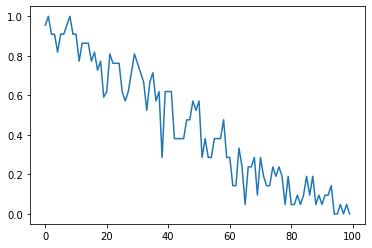

In [264]:
plt.plot(train_means)

In [180]:
y_train_pred_sorted = sorted(y_train_pred, reverse=True)
y_test_pred_sorted = sorted(y_test_pred, reverse=True)

In [150]:
y_train_pred = y_train_pred[::-1]
y_test_pred = y_test_pred[::-1]

In [181]:
y_train_pred_sorted

[0.9920433880406571,
 0.9918281954527343,
 0.9907357355037497,
 0.9905529593381981,
 0.9898521227020458,
 0.9895890359407166,
 0.9887243413400206,
 0.9879662817702691,
 0.9876957979998263,
 0.987663863280601,
 0.9866715849227689,
 0.9862473559970754,
 0.9853055446420999,
 0.9848514720701459,
 0.9841271619988662,
 0.9840982685259114,
 0.983992936396729,
 0.9838137074103346,
 0.9829112601131731,
 0.9826498250146569,
 0.9814752012471609,
 0.9801233154591742,
 0.9797861068673057,
 0.9791379381762094,
 0.9786725783022335,
 0.9783518428873234,
 0.9777299721937608,
 0.9772900389266237,
 0.9772313359108462,
 0.9768298194532382,
 0.9765834300311128,
 0.9760944157931808,
 0.9757609872916662,
 0.9750821739611463,
 0.9749995124468052,
 0.9749617505913266,
 0.9748078763510203,
 0.9746226949976655,
 0.9743560408604233,
 0.9742563734344594,
 0.9741073038097591,
 0.9734894122457004,
 0.9732428376544261,
 0.9731656152797612,
 0.9729212835741593,
 0.9729210582515428,
 0.9728170284886664,
 0.972548530884

In [152]:
y_train_pred.shape

(4946,)

In [153]:
y_test_pred.shape

(2120,)

In [158]:
2120 / 100

21.2

In [ ]:
train_bins = 